#### Notebook config

In [1]:
# %load ~/software/fullwavepy/fullwavepy/config/jupyter.py 
from fullwavepy import * # Load modules imported in fullwavepy/__init__.py
from arrau import *
# -----------------------------------------------------------------------------
# Set aliases of frequently used jupyter magic commands
# -----------------------------------------------------------------------------
%alias_magic mi matplotlib -p inline
%alias_magic mn matplotlib -p notebook
# -----------------------------------------------------------------------------
# Set matplotlib backend
# -----------------------------------------------------------------------------
# non-interactive plots displayed in a notebook cell
%matplotlib inline
# interactive plots displayed in a notebook cell
# %matplotlib notebook (interactive version)
# -----------------------------------------------------------------------------
# Set matplotlib style
# ----------------------------------------------------------------------------
plt.style.reload_library()
# a combined style (right overwrites left wherever they overlap):
plt.style.use(['default', 'ggplot'])
# print(plt.style.available) 
# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
# Set up loggers, handlers and load the log_lvl function
from fullwavepy.config.logging import *
# -----------------------------------------------------------------------------
# Set level of log-messages
log_lvl(20) 
# Other options in order of increasing importance and 
# decreasing verbosity:
# TRACE, DEBUG, INFO, WARNING, ERROR, CRITICAL
# or using integers: 0, 10, 20, 30, 40, 50, respectively
# -----------------------------------------------------------------------------
# Autocompleting
# -----------------------------------------------------------------------------
#  Not sure if it works
#%config IPCompleter.greedy=True 
# -----------------------------------------------------------------------------
# Automatically reload modules before execution
#%load_ext autoreload
#%autoreload 2
from matplotlib.gridspec import GridSpec
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])

# import matplotlib as mpl
# COLOR = 'Gray'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR

Created `%mi` as an alias for `%matplotlib inline`.
Created `%mn` as an alias for `%matplotlib notebook`.


In [2]:
exe = { 
    'fullwave':  '~/PhD/fullwave3D/rev690/bin/fullwave3D.exe',
    'fullwave_local': '/home/kmc3817/light_PhD/fullwave3D/rev690/bin/fullwave3D.exe',
    'segyprep':  '/home/kmc3817/light_PhD/fullwave3D/segyprep_v3.16/bin/segyprep_v3.16'} 

# v01: anim

In [3]:
# Init 
lll(40)
b01 = Box(x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3)
dis01 = {'dt': 0.0025, 'dx': 50, 'ns': 2000}
env = dict(SLAVES_WAVEFIELDSVTR=-100)
s01 = ProjSyn('s01', path = './', exe=exe, box=b01.box, **dis01, env=env, cat=0)
p = s01
# Geometry
babs, eabs = 50, 100
x1, x2, y1, y2, z1, z2 = b01.box
z = (z2 - z1) / 2
soux0 = (x2 - x1) / 4
recx0 = x1
# Anomaly
x_a = (x2 - x1) / 2
z_a = z
r_a = 5e2 # m
x_an, z_an, r_an = np.array([x_a, z_a, r_a]) // p.dx
x_an, z_an, r_an = [int(i) for i in [x_an, z_an, r_an ]]
ampl = -0.5 #  

# Arrays
vp = 5000 # m/s
bckg = np.full(s01.dims, vp)
anom = np.zeros(s01.dims)
anom[x_an-r_an:x_an+r_an+1, 0, z_an-r_an:z_an+r_an] = ampl

p.i.tvp.create(bckg + bckg * anom)
p.i.rsg.create(wavelet='ricker', fpeak=5)
tvp = Arr2d(p.i.tvp.read()[:,0,:], extent=[b01.extent[0],b01.extent[-1]])

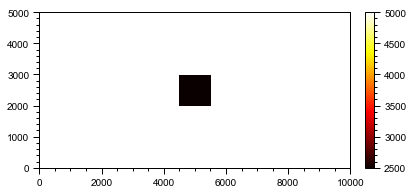

In [11]:
tvp.plot(cmap='hot')

In [41]:
# Preprocess 
p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d',
    souz=z, soux0=soux0, soudx=0, sounx=1,
    recz=z, recx0=recx0, recdx=p.dx, recnx=p.dims[0]*2)
# p.i.sp.cat()
p.i.sp.run(cat=0)
p.i.rnf.create(b_abs=babs, e_abs=eabs, btop=babs, etop=eabs)
# p.i.rnf.cat()
lll(40)

In [42]:
%%time 
no = 0
!rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
p.i.bash.no[no].create(cat=1)
p.i.bash.no[no].run()
# p.o.syn.plot()

CPU times: user 4 ms, sys: 12 ms, total: 16 ms
Wall time: 6.94 s


In [13]:
# Read snapshots 
from fullwavepy.seismic.wavefields import Wavefield
from fullwavepy.utils import extent2absorb
extent = extent2absorb(b01.extent, dx=p.dx, etop=p.etop, e_abs=eabs)
wfd = Wavefield()
wfd.get_files(p.name, p.o.path)
wf = {}
sid = 1
for ts, f in sorted(wfd.id[sid].items()):
    wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], extent=[extent[0],extent[-1]])

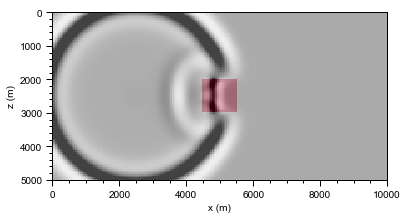

In [14]:
# Plot 
ts = 300
a = 500
tvp.plot(vmax=7500, cmap='coolwarm_r', cbar=0)
wf[ts].plot(cmap='Greys', vmin=-a, vmax=a, alpha=0.7, cbar=0)
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.xlim(b01.extent[0])
plt.ylim(b01.extent[-1])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

In [46]:
# Animate 
from matplotlib import animation, rc
from IPython.display import HTML
fig, ax = plt.subplots(figsize=(12,5))
im = plt.imshow(snaps[0].arr.T, cmap='coolwarm')
plt.close()
def animate(i):
    im.set_data(snaps[i].arr.T)
interval = 200 # time interval between frames, ms
anim = animation.FuncAnimation(fig, animate, frames=len(snaps), interval=interval)
rc('animation', html='jshtml') # to make it work on google colab
anim

# v02: widget

In [ ]:
def init_proj():
    pass
def create_model_array(anom_relative, background=5000):
    """
    dvp : float
        Relative vp anomaly. Fraction of the backg
    """

In [4]:
# Init 
lll(40)
b01 = Box(x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3)
dis01 = {'dt': 0.001, 'dx': 20, 'ns': 5000}
env = dict(SLAVES_WAVEFIELDSVTR=-100)
s02 = ProjSyn('s02', path = './', exe=exe, box=b01.box, **dis01, env=env, cat=0)
p = s02
# Geometry
babs, eabs = 50, 100
x1, x2, y1, y2, z1, z2 = b01.box
z = (z2 - z1) / 2
soux0 = (x2 - x1) / 4
recx0 = x1
# Anomaly
x_a = (x2 - x1) / 2
z_a = z
r_a = 5e2 # m
x_an, z_an, r_an = np.array([x_a, z_a, r_a]) // p.dx
x_an, z_an, r_an = [int(i) for i in [x_an, z_an, r_an ]]
ampl = -0.5 #  
# Arrays
vp = 5000 # m/s
bckg = np.full(s01.dims, vp)
anom = np.zeros(s01.dims)
anom[x_an-r_an:x_an+r_an+1, 0, z_an-r_an:z_an+r_an] = ampl

p.i.tvp.create(bckg + bckg * anom)
p.i.rsg.create(wavelet='ricker', fpeak=5)
tvp = Arr2d(p.i.tvp.read()[:,0,:], extent=[b01.extent[0],b01.extent[-1]])

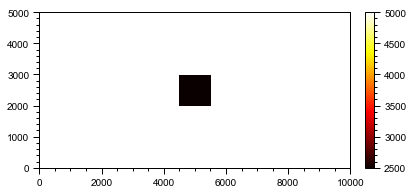

In [16]:
tvp.plot(cmap='hot')

In [17]:
# Preprocess 
p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d',
    souz=z, soux0=soux0, soudx=0, sounx=1,
    recz=z, recx0=recx0, recdx=p.dx, recnx=p.dims[0]*2)
# p.i.sp.cat()
p.i.sp.run(cat=0)
p.i.rnf.create(b_abs=babs, e_abs=eabs, btop=babs, etop=eabs)
# p.i.rnf.cat()
lll(40)

In [18]:
%%time 
no = 0
!rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
p.i.bash.no[no].create(cat=1)
p.i.bash.no[no].run()
# p.o.syn.plot()

rm: cannot remove './/s02//out/s02-Out0.log': No such file or directory
rm: cannot remove './/s02//out/s02-Err0.log': No such file or directory
CPU times: user 8 ms, sys: 20 ms, total: 28 ms
Wall time: 23.2 s


In [21]:
# Read snapshots 
from fullwavepy.seismic.wavefields import Wavefield
from fullwavepy.utils import extent2absorb
extent = extent2absorb(b01.extent, dx=p.dx, etop=p.etop, e_abs=eabs)
wfd = Wavefield()
wfd.get_files(p.name, p.o.path)
wf = {}
sid = 1
for ts, f in sorted(wfd.id[sid].items()):
    wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], extent=[extent[0],extent[-1]])

In [28]:
from ipywidgets import (interactive, interact, interact_manual, fixed,
                        IntSlider, FloatSlider, BoundedIntText, Dropdown,
                        SelectMultiple, Checkbox,
                        Layout, TwoByTwoLayout)

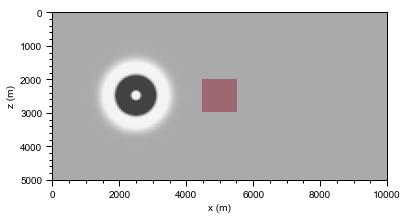

In [34]:
def plot(ts):
    tvp.plot(vmax=7500, cmap='coolwarm_r', cbar=0)
    wf[ts].plot(cmap='Greys', vmin=-a, vmax=a, alpha=0.7, cbar=0)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(b01.extent[0])
    plt.ylim(b01.extent[-1])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
plot(300)

In [36]:
@interact(timestep=BoundedIntText(min=100, max=5100, step=100))
def foo(timestep):
    plot(timestep)

interactive(children=(BoundedIntText(value=100, description='timestep', max=5100, min=100, step=100), Output()…

# v03

In [19]:
# Project parameters 
# Domain & its discretisation 
b01 = Box(x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3)
x1, x2, y1, y2, z1, z2 = b01.box
d01 = {'dt': 0.001, 'dx': 20, 'ns': 5000}
# Saving wavefield every nth time-step
nth = 100
env = dict(SLAVES_WAVEFIELDSVTR=-nth)
# Acquisition geometry
z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
srcs = dict(souz=z, soux0=((x2 - x1) / 4), soudx=0, sounx=1) # single source
recs = dict(recz=z, recx0=x1, recdx=p.dx, recnx=p.dims[0]*2) # receiver at every node at z
# Vp model 
vp = 5000 # (m/s)
print('Background Vp: %s km/s' % (vp / 1000))
# Source wavelet 
fpeak = 5 # dominant frequency of a Ricker wavelet (Hz)
print('Dominant frequency: %s Hz' % (fpeak))
wavelen = vp / fpeak
print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
# Vp anomaly
anom_amp = -0.5 # amplitude (fraction of the background model)
anom_pos = np.array([(x2 - x1) / 2, z]) // p.dx # centre of anomaly (nodes)
anom_rad = (wavelen // 2) // p.dx # radius (nodes) THIS SHOULD BE THE ENSEMBLE-VARIABLE
# Runfile parameters
eabs = 100 # no. of extra nodes along model edges
babs = 50  # absorbing boundaries' thickness (nodes)

Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km


In [15]:
# Initialise project
p = ProjSyn('s03', path = './', exe=exe, box=b01.box, **d01, env=env, cat=0)

In [5]:
# Arrays
bckg = np.full(p.dims, vp)
anom = np.zeros(bckg.shape)
[x, z], r = anom_pos.astype(int), int(anom_rad)
anom[x-r:x+r+1, 0, z-r:z+r+1] = anom_amp

NameError: name 'anom_pos' is not defined

In [29]:
# Create input 
p.i.rsg.create(wavelet='ricker', fpeak=fpeak)
p.i.tvp.create(bckg + bckg * anom)
tvp = Arr2d(p.i.tvp.read()[:,0,:], extent=[b01.extent[0],b01.extent[-1]]) # 2D
# Preprocess 
lll(40)
p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', **srcs, **recs)
# p.i.sp.cat()
p.i.sp.run(cat=0)
# Create runfile
p.i.rnf.create(b_abs=babs, e_abs=eabs, btop=babs, etop=eabs)
# p.i.rnf.cat()

In [42]:
#     kwargs['marker'] = kw('marker', '*', kwargs)
#     kwargs['markersize'] = kw('markersize', 10, kwargs)
#     kwargs['markeredgecolor'] = kw('markeredgecolor', 'k', kwargs)
#     kwargs['markerfacecolor'] = kw('markerfacecolor', 'w', kwargs)
s.li

[PointSR([126.,   1., 125.])]

In [104]:
# plotters 
def plot_src(size=10):
    s = [srcs['soux0'], srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot_recs(xmin=0, xmax=-1, size=2):
    # read
    xr = x1 + np.array([i[0]-1 for i in p.i.r.read().li]) * p.dx
    zr = z1 + np.array([i[2]-1 for i in p.i.r.read().li]) * p.dx
    plt.plot(xr[xmin:xmax], zr[xmin:xmax], 
            marker='o', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(ts, clip=3000):
    tvp.plot(vmax=7500, cmap='coolwarm_r', cbar=0)
    plot_src()
    wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=0.7, cbar=0)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(b01.extent[0])
    plt.ylim(b01.extent[-1])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 

In [112]:
wf[100].axes[0].extent

[-2000.0, 12000.0]

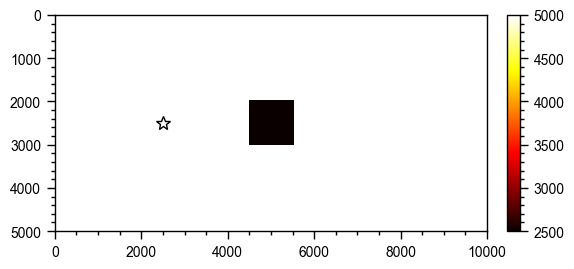

In [97]:
# plot input 
tvp.plot(cmap='hot')
plot_src()
# plot_recs(xmin=300, xmax=-10, size=1)
plt.gca().invert_yaxis()

In [90]:
%%time 
no = 0
!rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
p.i.bash.no[no].create(cat=1)
p.i.bash.no[no].run()
# p.o.syn.plot()

rm: cannot remove './/s03//out/s03-Out0.log': No such file or directory
rm: cannot remove './/s03//out/s03-Err0.log': No such file or directory
CPU times: user 8 ms, sys: 16 ms, total: 24 ms
Wall time: 22.3 s


In [92]:
# Read snapshots 
from fullwavepy.seismic.wavefields import Wavefield
from fullwavepy.utils import extent2absorb
p.reinit('./')
extent = extent2absorb(b01.extent, dx=p.dx, etop=p.etop, e_abs=eabs)
wfd = Wavefield()
wfd.get_files(p.name, p.o.path)
wf = {}
sid = 1
for ts, f in sorted(wfd.id[sid].items()):
    wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], extent=[extent[0],extent[-1]])

In [115]:
from ipywidgets import interact, BoundedIntText
@interact(timestep=BoundedIntText(min=100, max=5100, step=100))
def foo(timestep):
    plot(timestep, clip=500)

interactive(children=(BoundedIntText(value=100, description='timestep', max=5100, min=100, step=100), Output()…

# v04

In [166]:
# Functions 
def plot_src(srcs, size=10):
    s = [srcs['soux0'], srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot_recs(recs, xmin=0, xmax=-1, size=2):
    # read
    xr = x1 + np.array([i[0]-1 for i in p.i.r.read().li]) * p.dx
    zr = z1 + np.array([i[2]-1 for i in p.i.r.read().li]) * p.dx
    plt.plot(xr[xmin:xmax], zr[xmin:xmax], 
            marker='o', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(tvp, srcs, recs, ts, vp, anom_amp, clip=500, alpha=.7, cbar_vp=0, cbar_wf=0):
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin 
    elif anom_amp == 0:
        vmin, vmax = None, None
    tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', cbar=cbar_vp)
    plot_src(srcs)
    wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=cbar_wf)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(tvp.axes[0].extent)
    plt.ylim(tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
def run(proj_name, anom_rad_per_wavelen, anom_amp=-0.5, vp=5000, fpeak=5):
    # Domain & its discretisation 
    b01 = Box(x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3)
    x1, x2, y1, y2, z1, z2 = b01.box
    d01 = {'dt': 0.001, 'dx': 20, 'ns': 5000}
    # Saving wavefield every nth time-step
    nth = 100
    env = dict(SLAVES_WAVEFIELDSVTR=-nth)
    # Initialise project
    p = ProjSyn(proj_name, path = './', exe=exe, box=b01.box, **d01, env=env, cat=0)    
    # Acquisition geometry
    z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
    srcs = dict(souz=z, soux0=((x2 - x1) / 4), soudx=0, sounx=1) # single source
    recs = dict(recz=z, recx0=x1, recdx=p.dx, recnx=p.dims[0]*2) # receiver at every node at z
    # Vp model 
    vp = vp # (m/s)
    print('Background Vp: %s km/s' % (vp / 1000))
    # Source wavelet 
    fpeak = 5 # dominant frequency of a Ricker wavelet (Hz)
    print('Dominant frequency: %s Hz' % (fpeak))
    wavelen = vp / fpeak
    print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
    # Vp anomaly
    anom_amp = anom_amp # amplitude (fraction of the background model)
    anom_pos = np.array([(x2 - x1) / 2, z]) // p.dx # centre of anomaly (nodes)
    anom_rad = wavelen * anom_rad_per_wavelen // p.dx # radius (nodes) 
    # Runfile parameters
    eabs = 100 # no. of extra nodes along model edges
    babs = 50  # absorbing boundaries' thickness (nodes)
    # Arrays
    bckg = np.full(p.dims, vp)
    anom = np.zeros(bckg.shape)
    [x, z], r = anom_pos.astype(int), int(anom_rad)
    anom[x-r:x+r+1, 0, z-r:z+r+1] = anom_amp    
    # Create input 
    p.i.rsg.create(wavelet='ricker', fpeak=fpeak)
    p.i.tvp.create(bckg + bckg * anom)
    tvp = Arr2d(p.i.tvp.read()[:,0,:], extent=[b01.extent[0],b01.extent[-1]]) # 2D
    # Preprocess 
    lll(40)
    p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', **srcs, **recs)
    p.i.sp.run(cat=0)
    # Create runfile
    p.i.rnf.create(b_abs=babs, e_abs=eabs, btop=babs, etop=eabs)
    # Run locally 
    no = 0
    !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
    p.i.bash.no[no].create(cat=1)
    %time p.i.bash.no[no].run()    
    # Read snapshots 
    from fullwavepy.seismic.wavefields import Wavefield
    from fullwavepy.utils import extent2absorb
    p.reinit('./')
    extent = extent2absorb(b01.extent, dx=p.dx, etop=p.etop, e_abs=eabs)
    wfd = Wavefield()
    wfd.get_files(p.name, p.o.path)
    wf = {}
    sid = 1
    for ts, f in sorted(wfd.id[sid].items()):
        wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], extent=[extent[0],extent[-1]])    
    return p, tvp, srcs, recs, wf

In [161]:
vp = 5000 # m/s
amp = -0.5 # fraction of vp
pname = 's04'
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen=.5, anom_amp=amp, vp=vp, fpeak=5)

Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/s04//out/s04-Out0.log': No such file or directory
rm: cannot remove './/s04//out/s04-Err0.log': No such file or directory
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 22.3 s


In [162]:
from ipywidgets import interact, BoundedIntText
@interact(timestep=BoundedIntText(min=100, max=5100, step=100))
def foo(timestep):
    ts = timestep
    plot(tvp, srcs, recs, ts, vp, amp, clip=500, alpha=.7, cbar_vp=0, cbar_wf=0)

interactive(children=(BoundedIntText(value=100, description='timestep', max=5100, min=100, step=100), Output()…

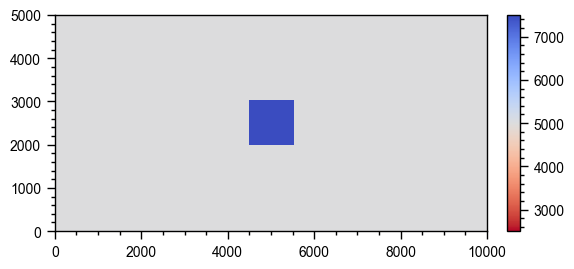

In [147]:
tvp.plot(vmin=2500, vmax=7500, cmap='coolwarm_r', cbar=1)

In [ ]:
    
    plot_src(srcs)
    wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=cbar_wf)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(tvp.axes[0].extent)
    plt.ylim(tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 

# v05: compare three

In [6]:
# Functions 
def plot_src(srcs, size=10):
    s = [srcs['soux0'], srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot_recs(recs, xmin=0, xmax=-1, size=2):
    # read
    xr = x1 + np.array([i[0]-1 for i in p.i.r.read().li]) * p.dx
    zr = z1 + np.array([i[2]-1 for i in p.i.r.read().li]) * p.dx
    plt.plot(xr[xmin:xmax], zr[xmin:xmax], 
            marker='o', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(tvp, srcs, recs, ts, vp, anom_amp, clip=500, alpha=.7, cbar_vp=0, cbar_wf=0):
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', cbar=cbar_vp)
    plot_src(srcs)
    wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=cbar_wf)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(tvp.axes[0].extent)
    plt.ylim(tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
def run(proj_name, anom_rad_per_wavelen, anom_amp=-0.5, vp=5000, fpeak=5):
    # Domain & its discretisation 
    b01 = Box(x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3)
    x1, x2, y1, y2, z1, z2 = b01.box
    d01 = {'dt': 0.001, 'dx': 20, 'ns': 5000}
    # Saving wavefield every nth time-step
    nth = 100
    env = dict(SLAVES_WAVEFIELDSVTR=-nth)
    # Initialise project
    p = ProjSyn(proj_name, path = './', exe=exe, box=b01.box, **d01, env=env, cat=0)    
    # Acquisition geometry
    z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
    srcs = dict(souz=z, soux0=((x2 - x1) / 4), soudx=0, sounx=1) # single source
    recs = dict(recz=z, recx0=x1, recdx=p.dx, recnx=p.dims[0]*2) # receiver at every node at z
    # Vp model 
    vp = vp # (m/s)
    print('Background Vp: %s km/s' % (vp / 1000))
    # Source wavelet 
    fpeak = 5 # dominant frequency of a Ricker wavelet (Hz)
    print('Dominant frequency: %s Hz' % (fpeak))
    wavelen = vp / fpeak
    print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
    # Vp anomaly
    anom_amp = anom_amp # amplitude (fraction of the background model)
    anom_pos = np.array([(x2 - x1) / 2, z]) // p.dx # centre of anomaly (nodes)
    anom_rad = wavelen * anom_rad_per_wavelen // p.dx # radius (nodes) 
    # Runfile parameters
    eabs = 100 # no. of extra nodes along model edges
    babs = 50  # absorbing boundaries' thickness (nodes)
    # Arrays
    bckg = np.full(p.dims, vp)
    anom = np.zeros(bckg.shape)
    [x, z], r = anom_pos.astype(int), int(anom_rad)
    anom[x-r:x+r+1, 0, z-r:z+r+1] = anom_amp    
    # Create input 
    p.i.rsg.create(wavelet='ricker', fpeak=fpeak)
    p.i.tvp.create(bckg + bckg * anom)
    tvp = Arr2d(p.i.tvp.read()[:,0,:], extent=[b01.extent[0],b01.extent[-1]]) # 2D
    # Preprocess 
    lll(40)
    p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', **srcs, **recs)
    p.i.sp.run(cat=0)
    # Create runfile
    p.i.rnf.create(b_abs=babs, e_abs=eabs, btop=babs, etop=eabs)
    # Run locally 
    no = 0
    !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
    p.i.bash.no[no].create(cat=1)
    %time p.i.bash.no[no].run()    
    # Read snapshots 
    from fullwavepy.seismic.wavefields import Wavefield
    from fullwavepy.utils import extent2absorb
    p.reinit('./')
    extent = extent2absorb(b01.extent, dx=p.dx, etop=p.etop, e_abs=eabs)
    wfd = Wavefield()
    wfd.get_files(p.name, p.o.path)
    wf = {}
    sid = 1
    for ts, f in sorted(wfd.id[sid].items()):
        wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], extent=[extent[0],extent[-1]])    
    return p, tvp, srcs, recs, wf

## No anomaly

In [174]:
vp = 5000 # m/s
amp = 0 # fraction of vp
pname = 'anom00'
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen=.5, anom_amp=amp, vp=vp, fpeak=5)

Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/anom00//out/anom00-Out0.log': No such file or directory
rm: cannot remove './/anom00//out/anom00-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 22 s


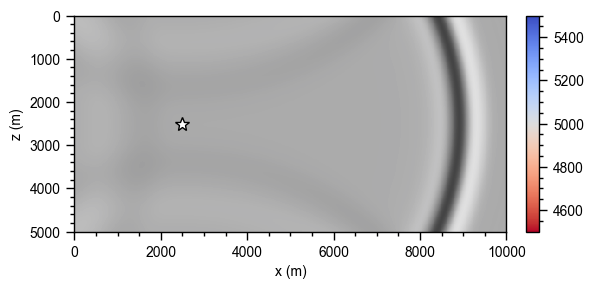

In [175]:
ts = 1500
plot(tvp, srcs, recs, ts, vp, amp, clip=500, alpha=.7, cbar_vp=1, cbar_wf=0)

## +50% anomaly

In [170]:
vp = 5000 # m/s
amp = 0.5 # fraction of vp
pname = 'anom05plus'
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen=.5, anom_amp=amp, vp=vp, fpeak=5)

Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/anom00//out/anom00-Out0.log': No such file or directory
rm: cannot remove './/anom00//out/anom00-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 22.5 s


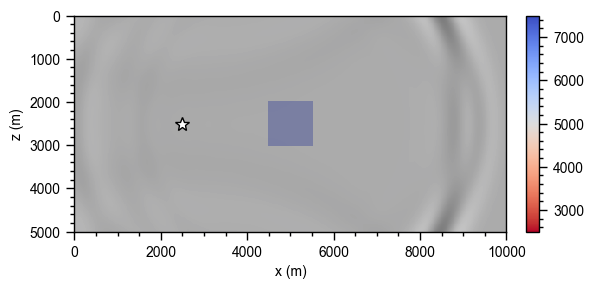

In [171]:
ts = 1500
plot(tvp, srcs, recs, ts, vp, amp, clip=500, alpha=.7, cbar_vp=1, cbar_wf=0)

## -50% anomaly

In [172]:
vp = 5000 # m/s
amp = -.5 # fraction of vp
pname = 'anom05minus'
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen=.5, anom_amp=amp, vp=vp, fpeak=5)

rm: cannot remove 'anom05minus': No such file or directory
Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/anom05minus//out/anom05minus-Out0.log': No such file or directory
rm: cannot remove './/anom05minus//out/anom05minus-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 22 s


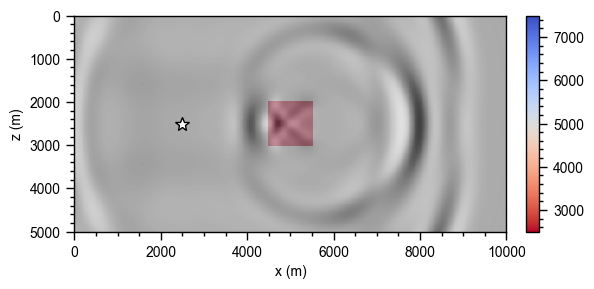

In [173]:
ts = 1500
plot(tvp, srcs, recs, ts, vp, amp, clip=500, alpha=.7, cbar_vp=1, cbar_wf=0)

# v06: smaller square

In [186]:
# Functions 
def plot_src(srcs, size=10):
    s = [srcs['soux0'], srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot_recs(recs, xmin=0, xmax=-1, size=2):
    # read
    xr = x1 + np.array([i[0]-1 for i in p.i.r.read().li]) * p.dx
    zr = z1 + np.array([i[2]-1 for i in p.i.r.read().li]) * p.dx
    plt.plot(xr[xmin:xmax], zr[xmin:xmax], 
            marker='o', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(tvp, srcs, recs, ts, vp, anom_amp, clip=500, alpha=.7, cbar_vp=0, cbar_wf=0):
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', cbar=cbar_vp)
    plot_src(srcs)
    wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=cbar_wf)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(tvp.axes[0].extent)
    plt.ylim(tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
def run(proj_name, anom_rad_per_wavelen, anom_amp=-0.5, vp=5000, fpeak=5):
    # Domain & its discretisation 
    b01 = Box(x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3)
    x1, x2, y1, y2, z1, z2 = b01.box
    d01 = {'dt': 0.001, 'dx': 20, 'ns': 5000}
    # Saving wavefield every nth time-step
    nth = 100
    env = dict(SLAVES_WAVEFIELDSVTR=-nth)
    # Initialise project
    p = ProjSyn(proj_name, path = './', exe=exe, box=b01.box, **d01, env=env, cat=0)    
    # Acquisition geometry
    z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
    srcs = dict(souz=z, soux0=((x2 - x1) / 4), soudx=0, sounx=1) # single source
    recs = dict(recz=z, recx0=x1, recdx=p.dx, recnx=p.dims[0]*2) # receiver at every node at z
    # Vp model 
    vp = vp # (m/s)
    print('Background Vp: %s km/s' % (vp / 1000))
    # Source wavelet 
    fpeak = 5 # dominant frequency of a Ricker wavelet (Hz)
    print('Dominant frequency: %s Hz' % (fpeak))
    wavelen = vp / fpeak
    print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
    # Vp anomaly
    anom_amp = anom_amp # amplitude (fraction of the background model)
    anom_pos = np.array([(x2 - x1) / 2, z]) // p.dx # centre of anomaly (nodes)
    anom_rad = wavelen * anom_rad_per_wavelen // p.dx # radius (nodes) 
    # Runfile parameters
    eabs = 100 # no. of extra nodes along model edges
    babs = 50  # absorbing boundaries' thickness (nodes)
    # Arrays
    bckg = np.full(p.dims, vp)
    anom = np.zeros(bckg.shape)
    [x, z], r = anom_pos.astype(int), int(anom_rad)
    anom[x-r:x+r+1, 0, z-r:z+r+1] = anom_amp    
    # Create input 
    p.i.rsg.create(wavelet='ricker', fpeak=fpeak)
    p.i.tvp.create(bckg + bckg * anom)
    tvp = Arr2d(p.i.tvp.read()[:,0,:], extent=[b01.extent[0],b01.extent[-1]]) # 2D
    # Preprocess 
    lll(40)
    p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', **srcs, **recs)
    p.i.sp.run(cat=0)
    # Create runfile
    p.i.rnf.create(b_abs=babs, e_abs=eabs, btop=babs, etop=eabs)
    # Run locally 
    no = 0
    !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
    p.i.bash.no[no].create(cat=1)
    %time p.i.bash.no[no].run()    
    # Read snapshots 
    from fullwavepy.seismic.wavefields import Wavefield
    from fullwavepy.utils import extent2absorb
    p.reinit('./')
    extent = extent2absorb(b01.extent, dx=p.dx, etop=p.etop, e_abs=eabs)
    wfd = Wavefield()
    wfd.get_files(p.name, p.o.path)
    wf = {}
    sid = 1
    for ts, f in sorted(wfd.id[sid].items()):
        wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], extent=[extent[0],extent[-1]])    
    return p, tvp, srcs, recs, wf

In [187]:
# Common variables 
vp = 5000 # m/s
fpeak = 5 # Hz
anom_rad_per_wavelen = 0.25
amp = 0.5
# Plotting 
ts = 1500 # timestep to plot 
clip = 500
alpha = .7
cbar_vp = 1
cbar_wf = 0

## No anomaly

Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/anom00//out/anom00-Out0.log': No such file or directory
rm: cannot remove './/anom00//out/anom00-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 22.2 s


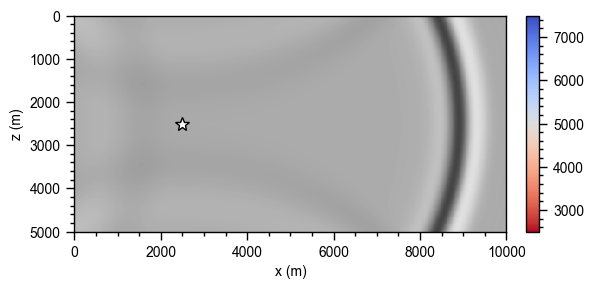

In [188]:
sign = 0
anom_amp = sign * amp
pname = 'anom00'
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen, anom_amp, vp, fpeak)
plot(tvp, srcs, recs, ts, vp, amp, clip, alpha, cbar_vp, cbar_wf)

## +50% anomaly

rm: cannot remove 'anom_plus': No such file or directory
Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/anom_plus//out/anom_plus-Out0.log': No such file or directory
rm: cannot remove './/anom_plus//out/anom_plus-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 22.1 s


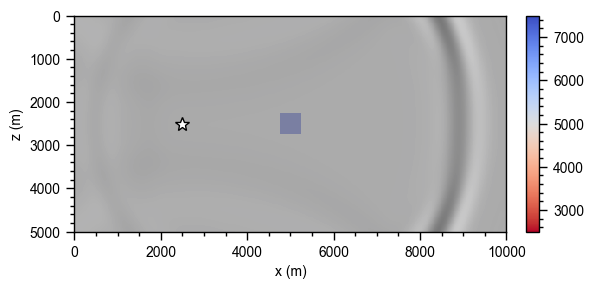

In [189]:
sign = +1
pname = 'anom_plus'
anom_amp = sign * amp
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen, anom_amp, vp, fpeak)
plot(tvp, srcs, recs, ts, vp, amp, clip, alpha, cbar_vp, cbar_wf)

## -50% anomaly

Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/anom_minus//out/anom_minus-Out0.log': No such file or directory
rm: cannot remove './/anom_minus//out/anom_minus-Err0.log': No such file or directory
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 21.8 s


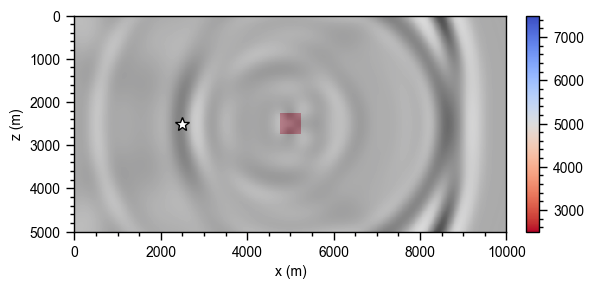

In [191]:
sign = -1
pname = 'anom_minus'
anom_amp = sign * amp
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen, anom_amp, vp, fpeak)
plot(tvp, srcs, recs, ts, vp, amp, clip, alpha, cbar_vp, cbar_wf)

# v06: larger square

In [192]:
# Functions 
def plot_src(srcs, size=10):
    s = [srcs['soux0'], srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot_recs(recs, xmin=0, xmax=-1, size=2):
    # read
    xr = x1 + np.array([i[0]-1 for i in p.i.r.read().li]) * p.dx
    zr = z1 + np.array([i[2]-1 for i in p.i.r.read().li]) * p.dx
    plt.plot(xr[xmin:xmax], zr[xmin:xmax], 
            marker='o', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(tvp, srcs, recs, ts, vp, anom_amp, clip=500, alpha=.7, cbar_vp=0, cbar_wf=0):
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', cbar=cbar_vp)
    plot_src(srcs)
    wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=cbar_wf)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(tvp.axes[0].extent)
    plt.ylim(tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
def run(proj_name, anom_rad_per_wavelen, anom_amp=-0.5, vp=5000, fpeak=5):
    # Domain & its discretisation 
    b01 = Box(x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3)
    x1, x2, y1, y2, z1, z2 = b01.box
    d01 = {'dt': 0.001, 'dx': 20, 'ns': 5000}
    # Saving wavefield every nth time-step
    nth = 100
    env = dict(SLAVES_WAVEFIELDSVTR=-nth)
    # Initialise project
    p = ProjSyn(proj_name, path = './', exe=exe, box=b01.box, **d01, env=env, cat=0)    
    # Acquisition geometry
    z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
    srcs = dict(souz=z, soux0=((x2 - x1) / 4), soudx=0, sounx=1) # single source
    recs = dict(recz=z, recx0=x1, recdx=p.dx, recnx=p.dims[0]*2) # receiver at every node at z
    # Vp model 
    vp = vp # (m/s)
    print('Background Vp: %s km/s' % (vp / 1000))
    # Source wavelet 
    fpeak = 5 # dominant frequency of a Ricker wavelet (Hz)
    print('Dominant frequency: %s Hz' % (fpeak))
    wavelen = vp / fpeak
    print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
    # Vp anomaly
    anom_amp = anom_amp # amplitude (fraction of the background model)
    anom_pos = np.array([(x2 - x1) / 2, z]) // p.dx # centre of anomaly (nodes)
    anom_rad = wavelen * anom_rad_per_wavelen // p.dx # radius (nodes) 
    # Runfile parameters
    eabs = 100 # no. of extra nodes along model edges
    babs = 50  # absorbing boundaries' thickness (nodes)
    # Arrays
    bckg = np.full(p.dims, vp)
    anom = np.zeros(bckg.shape)
    [x, z], r = anom_pos.astype(int), int(anom_rad)
    anom[x-r:x+r+1, 0, z-r:z+r+1] = anom_amp    
    # Create input 
    p.i.rsg.create(wavelet='ricker', fpeak=fpeak)
    p.i.tvp.create(bckg + bckg * anom)
    tvp = Arr2d(p.i.tvp.read()[:,0,:], extent=[b01.extent[0],b01.extent[-1]]) # 2D
    # Preprocess 
    lll(40)
    p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', **srcs, **recs)
    p.i.sp.run(cat=0)
    # Create runfile
    p.i.rnf.create(b_abs=babs, e_abs=eabs, btop=babs, etop=eabs)
    # Run locally 
    no = 0
    !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
    p.i.bash.no[no].create(cat=1)
    %time p.i.bash.no[no].run()    
    # Read snapshots 
    from fullwavepy.seismic.wavefields import Wavefield
    from fullwavepy.utils import extent2absorb
    p.reinit('./')
    extent = extent2absorb(b01.extent, dx=p.dx, etop=p.etop, e_abs=eabs)
    wfd = Wavefield()
    wfd.get_files(p.name, p.o.path)
    wf = {}
    sid = 1
    for ts, f in sorted(wfd.id[sid].items()):
        wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], extent=[extent[0],extent[-1]])    
    return p, tvp, srcs, recs, wf

In [197]:
# Common variables 
vp = 5000 # m/s
fpeak = 5 # Hz
anom_rad_per_wavelen = 1.25
amp = 0.5
# Plotting 
ts = 1500 # timestep to plot 
clip = 500
alpha = .7
cbar_vp = 1
cbar_wf = 0

## No anomaly

Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/anom00//out/anom00-Out0.log': No such file or directory
rm: cannot remove './/anom00//out/anom00-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 22.2 s


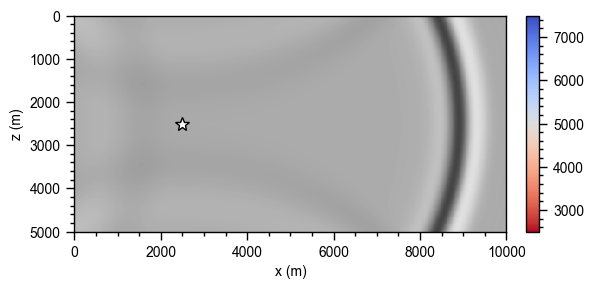

In [188]:
sign = 0
anom_amp = sign * amp
pname = 'anom00'
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen, anom_amp, vp, fpeak)
plot(tvp, srcs, recs, ts, vp, amp, clip, alpha, cbar_vp, cbar_wf)

## +50% anomaly

Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/anom_plus//out/anom_plus-Out0.log': No such file or directory
rm: cannot remove './/anom_plus//out/anom_plus-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 22.7 s


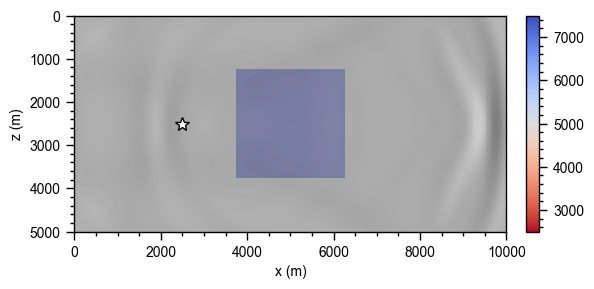

In [198]:
sign = +1
pname = 'anom_plus'
anom_amp = sign * amp
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen, anom_amp, vp, fpeak)
plot(tvp, srcs, recs, ts, vp, amp, clip, alpha, cbar_vp, cbar_wf)

## -50% anomaly

Background Vp: 5.0 km/s
Dominant frequency: 5 Hz
Dominant wavelength in the background Vp: 1.0 km
rm: cannot remove './/anom_minus//out/anom_minus-Out0.log': No such file or directory
rm: cannot remove './/anom_minus//out/anom_minus-Err0.log': No such file or directory
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 22.1 s


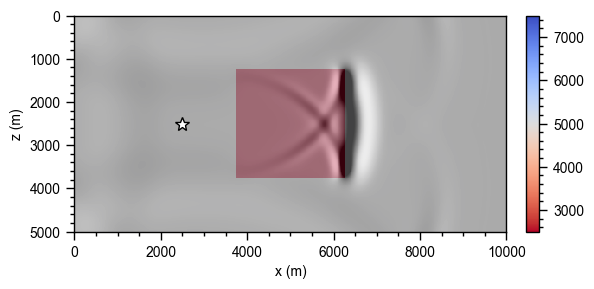

In [199]:
sign = -1
pname = 'anom_minus'
anom_amp = sign * amp
!rm {pname} -r
p, tvp, srcs, recs, wf = run(pname, anom_rad_per_wavelen, anom_amp, vp, fpeak)
plot(tvp, srcs, recs, ts, vp, amp, clip, alpha, cbar_vp, cbar_wf)

# v07: traces

## Definitions

## Input

In [175]:
en = Ensemble('test', './', exe, anom_rad_per_wavelen=0.5, anom_amp=0.5)
en.init_pars(ns=5000)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [74]:
en.run()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 22.5 s
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 22.3 s
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 22.2 s


In [176]:
en.prep_out()

## Output

In [180]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=1000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.tvp = Arr2d(p.i.tvp.read()[:,0,:], 
                          extent=[self.b01.extent[0],self.b01.extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    s = [en.srcs['soux0'], en.srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    trids = [-150, -10]
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        plt.xlim(.8,2.2)
        plt.legend()        

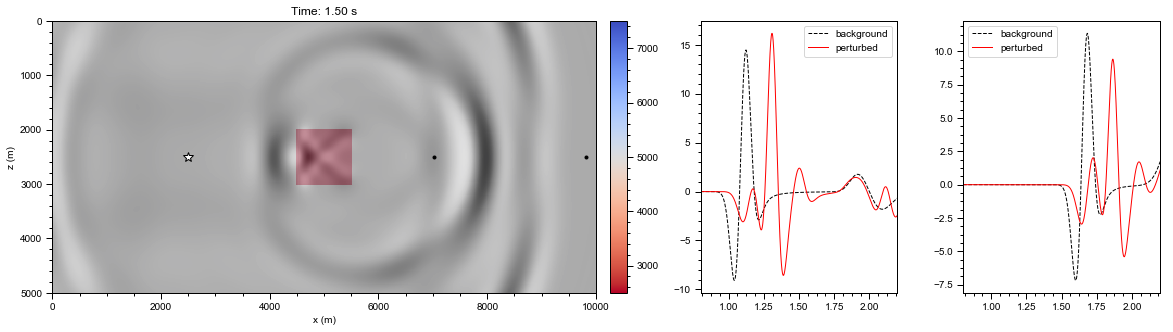

In [181]:
plot(en, 1500)

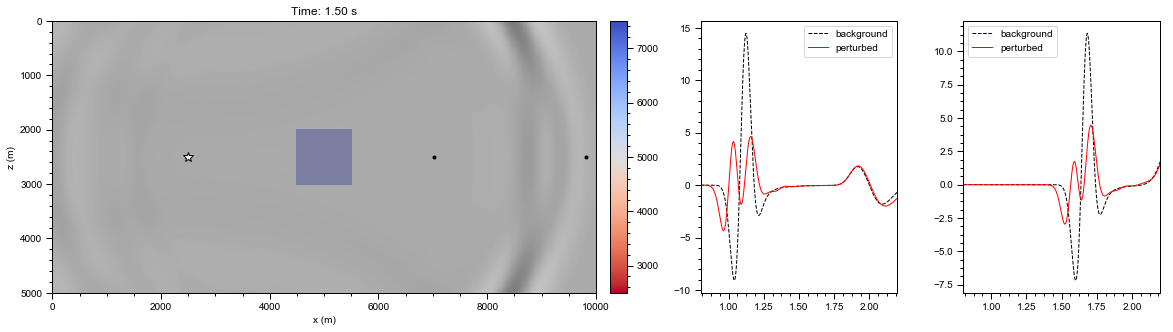

In [184]:
plot(en, 1500, sign='+')

In [183]:
from ipywidgets import interact, BoundedIntText
@interact(timestep=BoundedIntText(min=100, max=5100, step=100))
def foo(timestep):
    plot(en, timestep)

interactive(children=(BoundedIntText(value=100, description='timestep', max=5100, min=100, step=100), Output()…

# v08: smaller square

## Definitions

In [12]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=1000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.tvp = Arr2d(p.i.tvp.read()[:,0,:], 
                          extent=[self.b01.extent[0],self.b01.extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    s = [en.srcs['soux0'], en.srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    trids = [-150, -10]
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        plt.xlim(.8,2.2)
        plt.legend()        

## Input

In [8]:
en = Ensemble('test', './', exe, anom_rad_per_wavelen=0.25, anom_amp=0.5)
en.init_pars(ns=5000)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [9]:
en.run()

rm: cannot remove './/test_25_50_null//out/test_25_50_null-Out0.log': No such file or directory
rm: cannot remove './/test_25_50_null//out/test_25_50_null-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 22.2 s
rm: cannot remove './/test_25_50_plus//out/test_25_50_plus-Out0.log': No such file or directory
rm: cannot remove './/test_25_50_plus//out/test_25_50_plus-Err0.log': No such file or directory
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 22 s
rm: cannot remove './/test_25_50_minus//out/test_25_50_minus-Out0.log': No such file or directory
rm: cannot remove './/test_25_50_minus//out/test_25_50_minus-Err0.log': No such file or directory
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 22.1 s


In [10]:
en.prep_out()

## Output

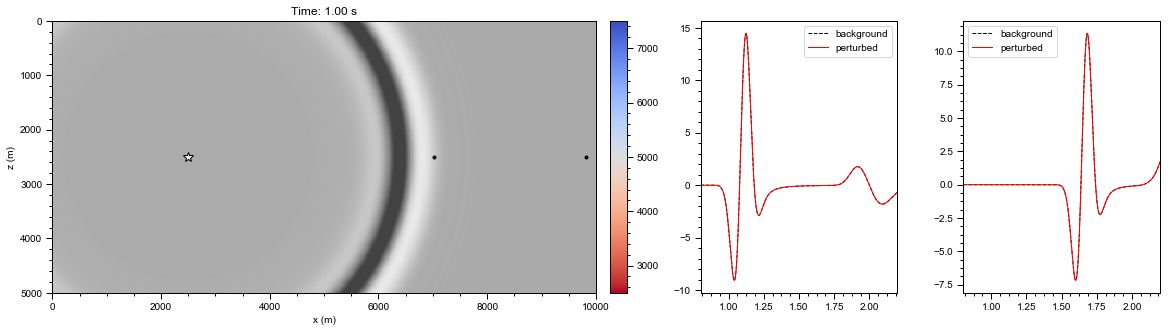

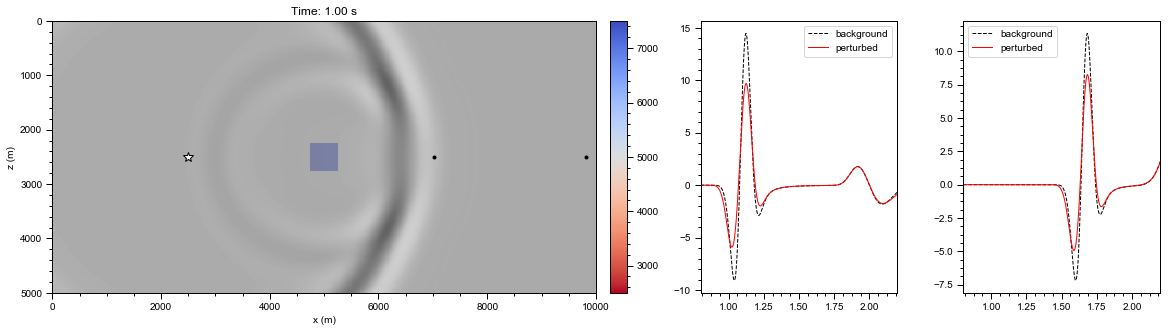

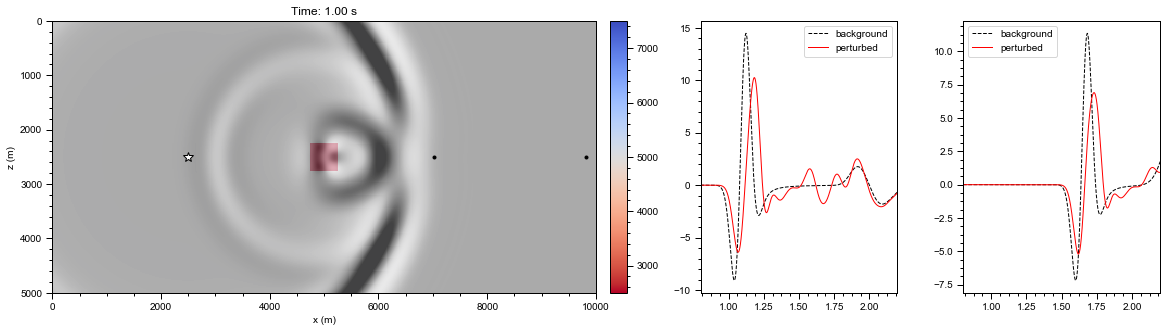

In [14]:
for ts in [1000]:
    plot(en, ts, sign='0')
    plot(en, ts, sign='+')
    plot(en, ts, sign='-')

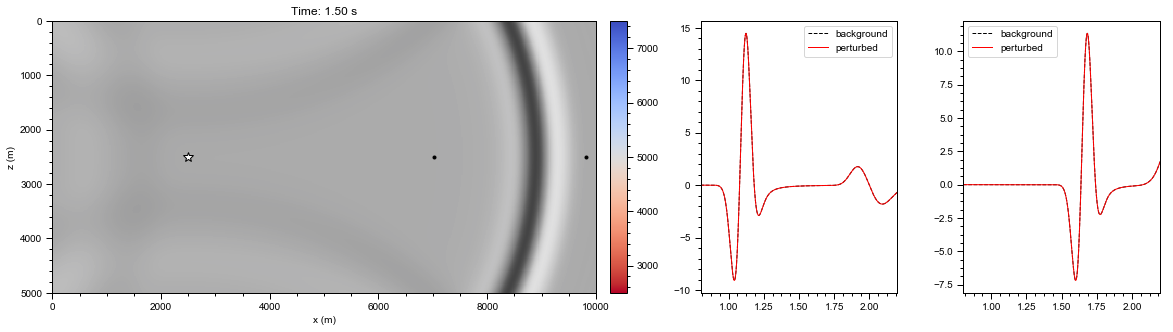

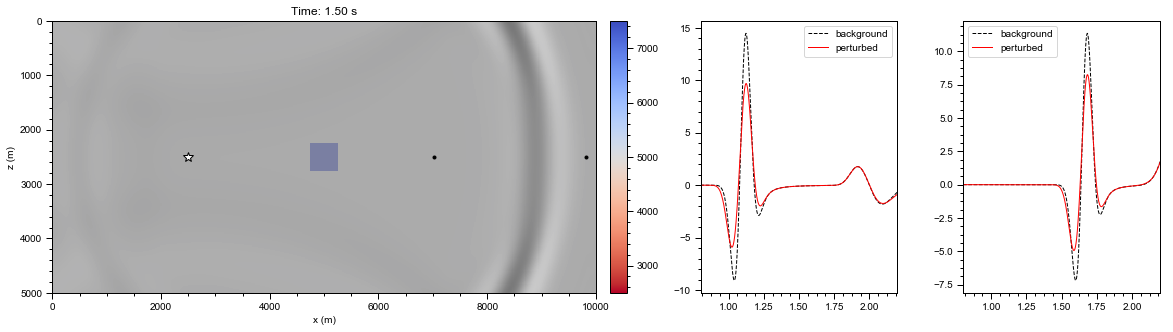

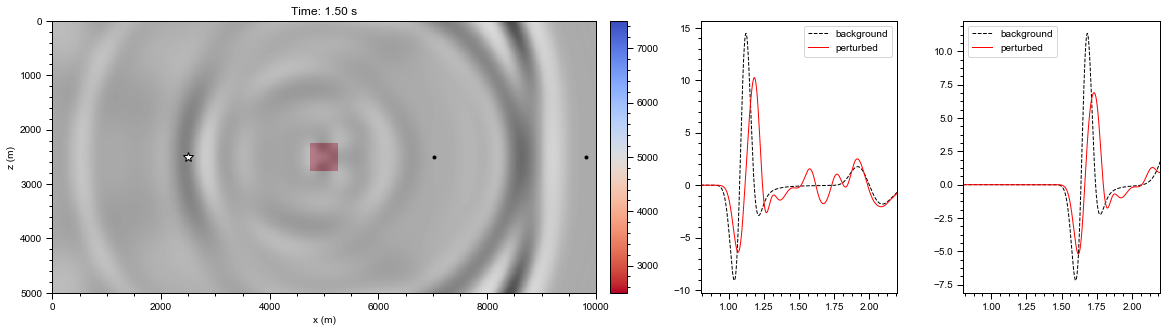

In [13]:
for ts in [1500]:
    plot(en, ts, sign='0')
    plot(en, ts, sign='+')
    plot(en, ts, sign='-')

In [ ]:
# from ipywidgets import interact, BoundedIntText
# @interact(timestep=BoundedIntText(min=100, max=5100, step=100))
# def foo(timestep):
#     plot(en, timestep)

# v09: larger square

## Definitions

In [21]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=1000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.tvp = Arr2d(p.i.tvp.read()[:,0,:], 
                          extent=[self.b01.extent[0],self.b01.extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    s = [en.srcs['soux0'], en.srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, tlim=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        plt.xlim(tlim)
        plt.legend()        

## Input

In [9]:
en = Ensemble('test', './', exe, anom_rad_per_wavelen=1, anom_amp=0.5)
en.init_pars(x2=1.5e4, ns=5000, babs=100, eabs=150)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [10]:
en.run()

rm: cannot remove './/test_100_50_plus//out/test_100_50_plus-Out0.log': No such file or directory
rm: cannot remove './/test_100_50_plus//out/test_100_50_plus-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 33.4 s
rm: cannot remove './/test_100_50_null//out/test_100_50_null-Out0.log': No such file or directory
rm: cannot remove './/test_100_50_null//out/test_100_50_null-Err0.log': No such file or directory
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 32.5 s
rm: cannot remove './/test_100_50_minus//out/test_100_50_minus-Out0.log': No such file or directory
rm: cannot remove './/test_100_50_minus//out/test_100_50_minus-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 32.4 s


In [10]:
en.prep_out()

## Output

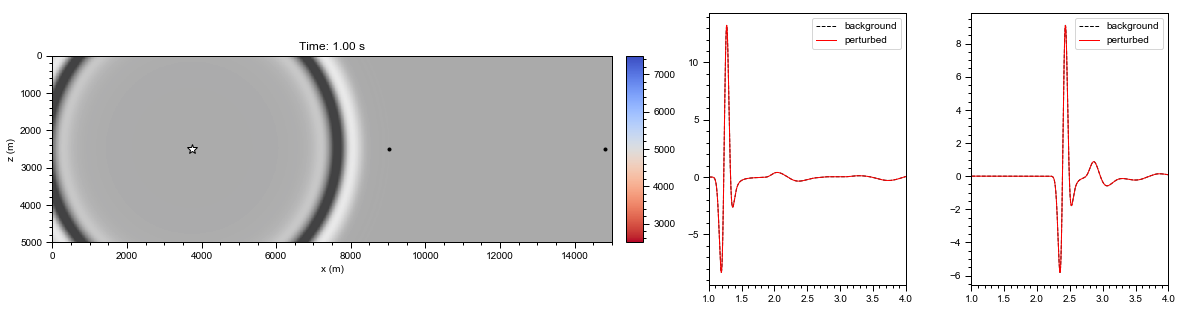

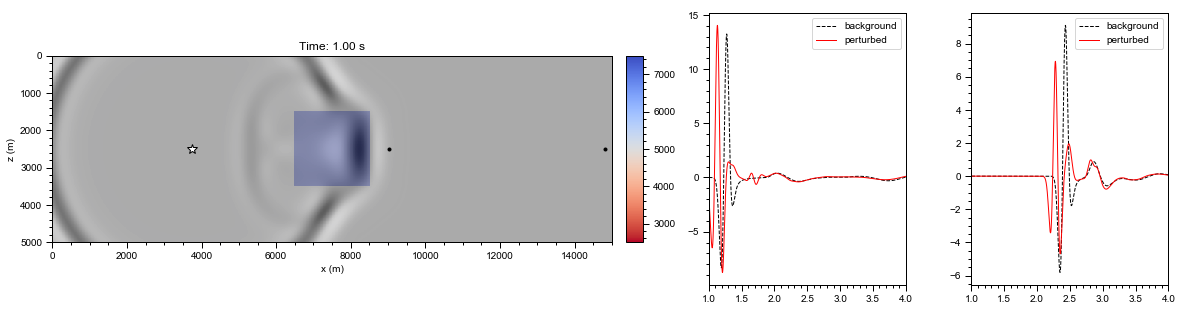

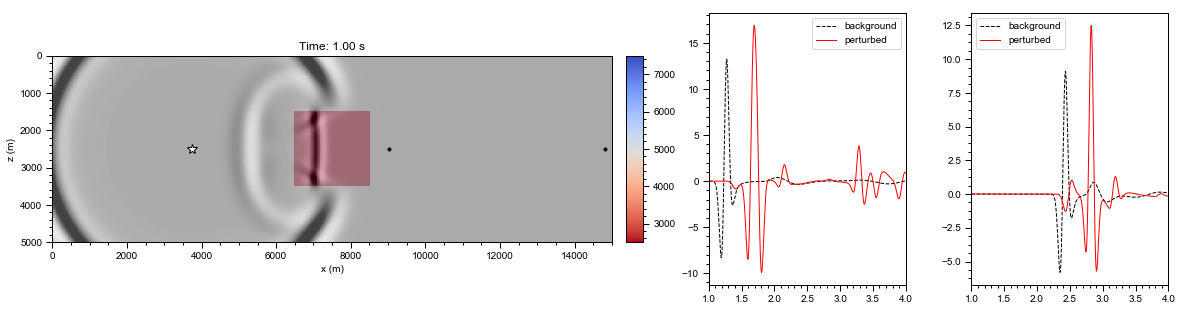

In [23]:
ts = 1000
kws = dict(trids=[-300,-10], tlim=[1,4])
for sign in ['0', '+', '-']:
    plot(en, ts, sign=sign, **kws)

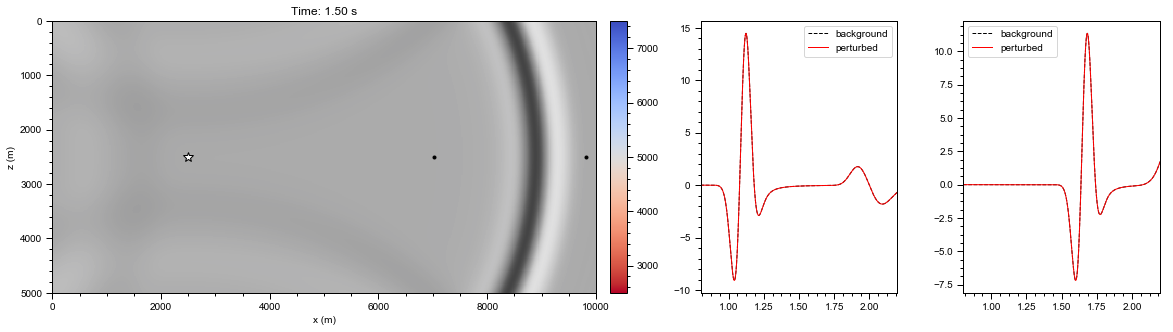

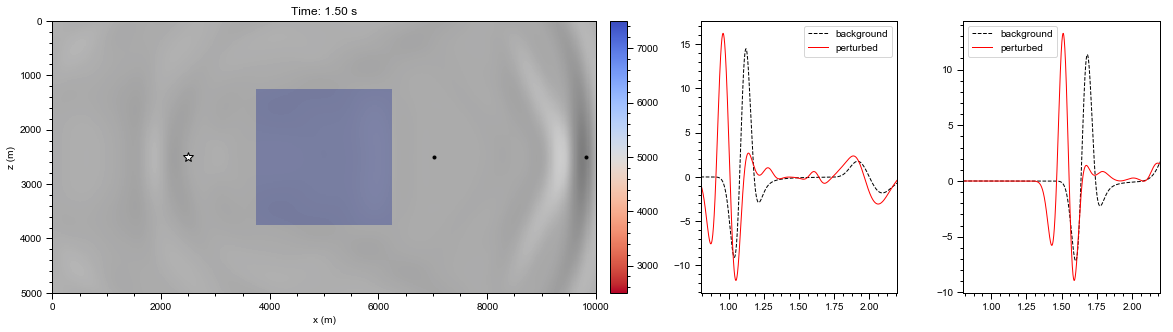

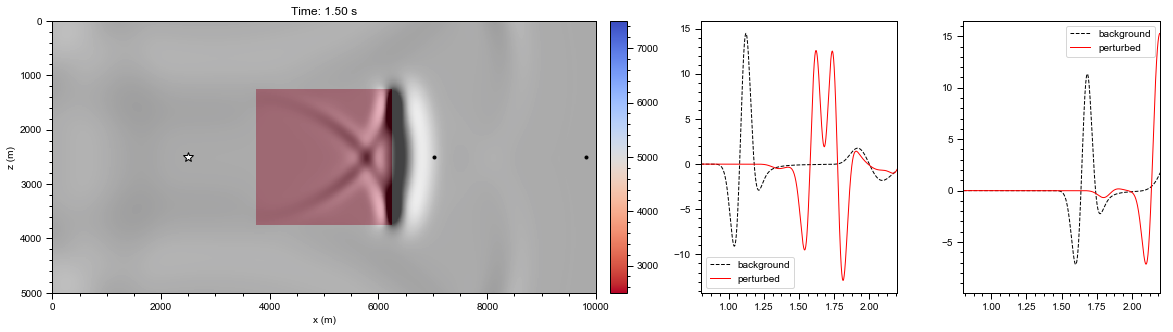

In [20]:
for ts in [1500]:
    plot(en, ts, sign='0')
    plot(en, ts, sign='+')
    plot(en, ts, sign='-')

In [ ]:
# from ipywidgets import interact, BoundedIntText
# @interact(timestep=BoundedIntText(min=100, max=5100, step=100))
# def foo(timestep):
#     plot(en, timestep)

# v10

## Definitions

In [59]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=1000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:], 
                          extent=[self.b01.extent[0],self.b01.extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    s = [en.srcs['soux0'], en.srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.legend()        

## Input

In [56]:
en = Ensemble('test', './', exe, anom_rad_per_wavelen=0.5, anom_amp=0.5)
en.init_pars(x2=1.5e4, ns=5000, babs=100, eabs=150)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [26]:
en.run()

CPU times: user 4 ms, sys: 12 ms, total: 16 ms
Wall time: 32.5 s
CPU times: user 0 ns, sys: 12 ms, total: 12 ms
Wall time: 32.5 s
CPU times: user 4 ms, sys: 12 ms, total: 16 ms
Wall time: 33.1 s


In [57]:
en.prep_out()

## Output

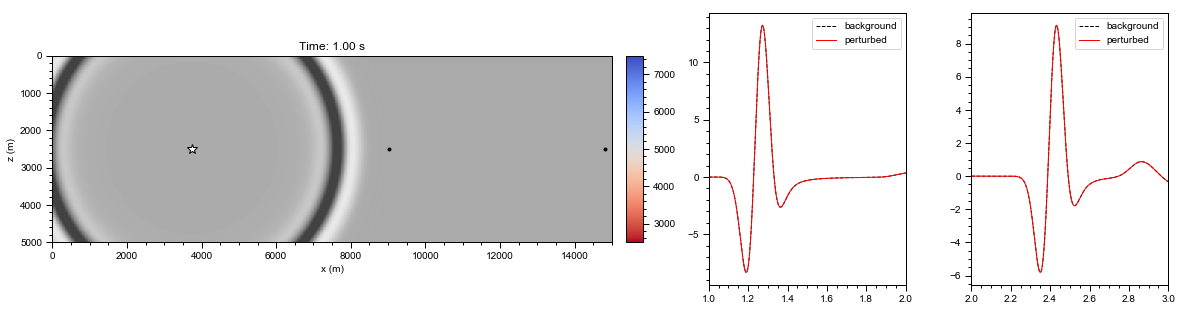

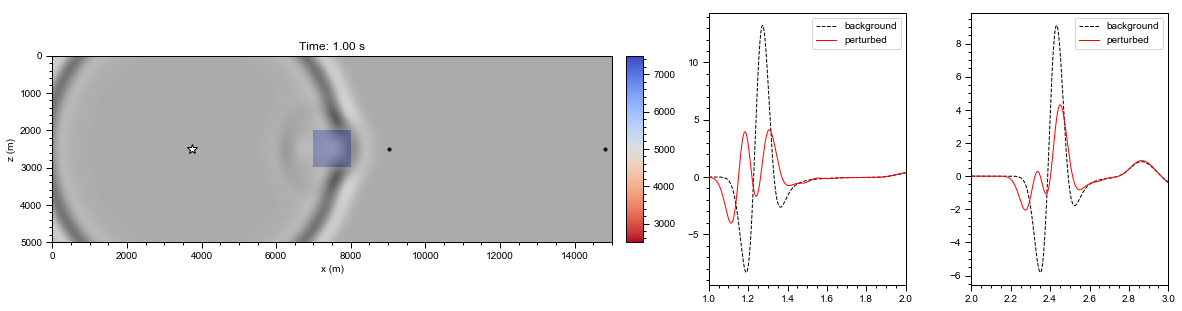

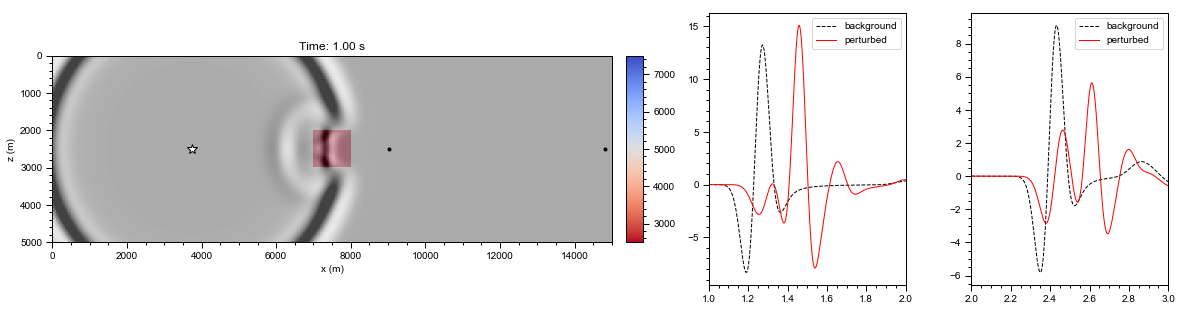

In [62]:
ts = 1000
kws = dict(trids=[-300,-10], tlim1=[1,2], tlim2=[2,3])
for sign in ['0', '+', '-']:
    plot(en, ts, sign=sign, **kws)

# v11: smaller but stronger

## Definitions

In [64]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=1000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:], 
                          extent=[self.b01.extent[0],self.b01.extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    s = [en.srcs['soux0'], en.srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='vp (m/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [69]:
en = Ensemble('test', './', exe, anom_rad_per_wavelen=0.25, anom_amp=0.75)
en.init_pars(x2=1.5e4, ns=3000, babs=100, eabs=150)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [70]:
en.run()

rm: cannot remove './/test_25_75_minus//out/test_25_75_minus-Out0.log': No such file or directory
rm: cannot remove './/test_25_75_minus//out/test_25_75_minus-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 20 ms, total: 24 ms
Wall time: 16.5 s
rm: cannot remove './/test_25_75_null//out/test_25_75_null-Out0.log': No such file or directory
rm: cannot remove './/test_25_75_null//out/test_25_75_null-Err0.log': No such file or directory
CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 16.5 s
rm: cannot remove './/test_25_75_plus//out/test_25_75_plus-Out0.log': No such file or directory
rm: cannot remove './/test_25_75_plus//out/test_25_75_plus-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 16.8 s


In [71]:
en.prep_out()

## Output

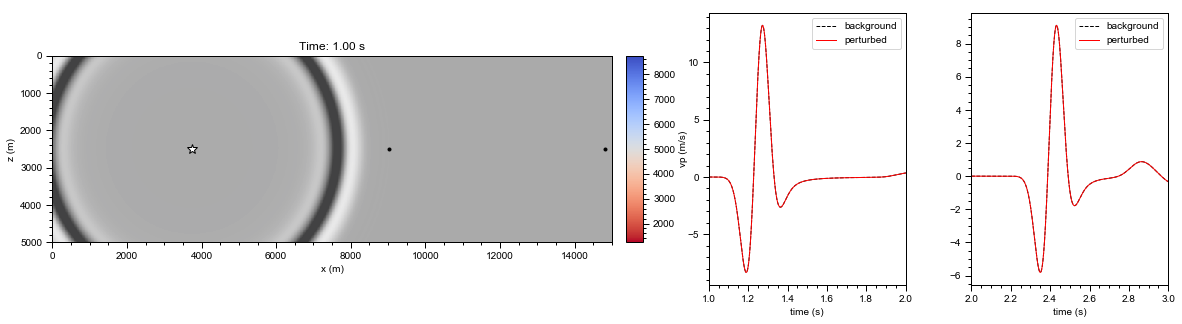

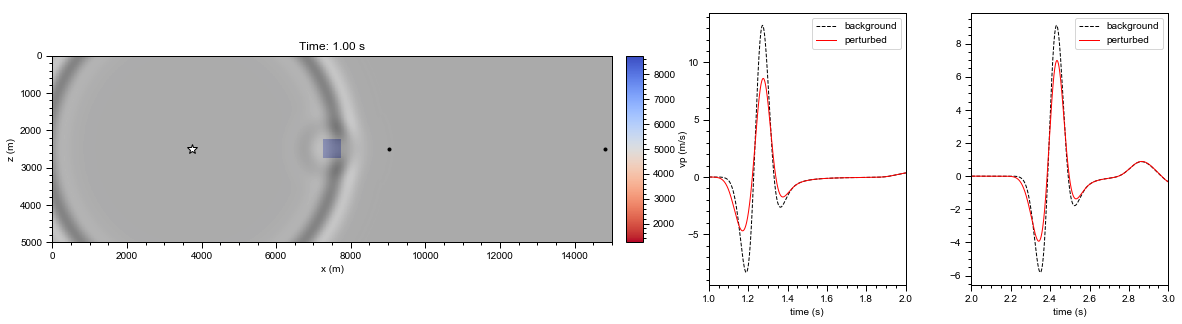

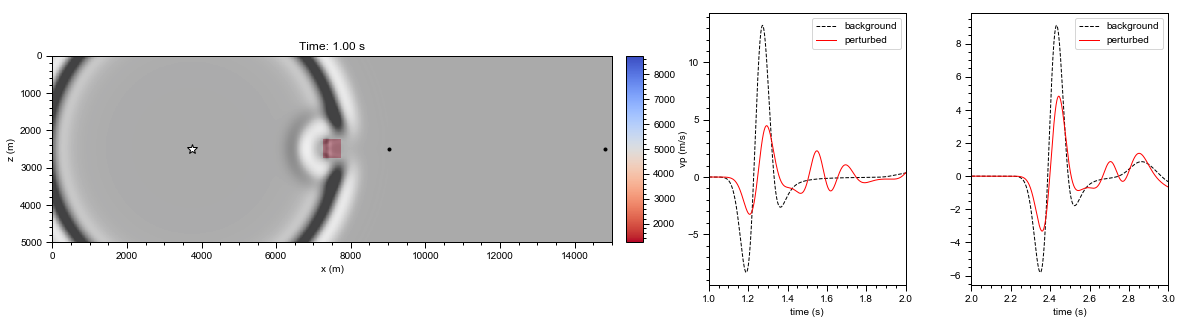

In [72]:
ts = 1000
kws = dict(trids=[-300,-10], tlim1=[1,2], tlim2=[2,3])
for sign in ['0', '+', '-']:
    plot(en, ts, sign=sign, **kws)

# v12: 

## Definitions

In [87]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=1000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:], 
                          extent=[self.b01.extent[0],self.b01.extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    s = [en.srcs['soux0'], en.srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2], figsize=(20,5), width_ratios=[3,1,1]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(1, 3, width_ratios=width_ratios)
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='vp (m/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [83]:
en = Ensemble('test', './', exe, anom_rad_per_wavelen=0.5, anom_amp=0.75)
en.init_pars(x2=1.5e4, ns=3000, babs=100, eabs=150)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [75]:
en.run()

rm: cannot remove './/test_50_75_minus//out/test_50_75_minus-Out0.log': No such file or directory
rm: cannot remove './/test_50_75_minus//out/test_50_75_minus-Err0.log': No such file or directory
CPU times: user 0 ns, sys: 20 ms, total: 20 ms
Wall time: 16.5 s
rm: cannot remove './/test_50_75_null//out/test_50_75_null-Out0.log': No such file or directory
rm: cannot remove './/test_50_75_null//out/test_50_75_null-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 12 ms, total: 16 ms
Wall time: 16.6 s
rm: cannot remove './/test_50_75_plus//out/test_50_75_plus-Out0.log': No such file or directory
rm: cannot remove './/test_50_75_plus//out/test_50_75_plus-Err0.log': No such file or directory
CPU times: user 0 ns, sys: 16 ms, total: 16 ms
Wall time: 17.9 s


In [85]:
en.prep_out()

## Output

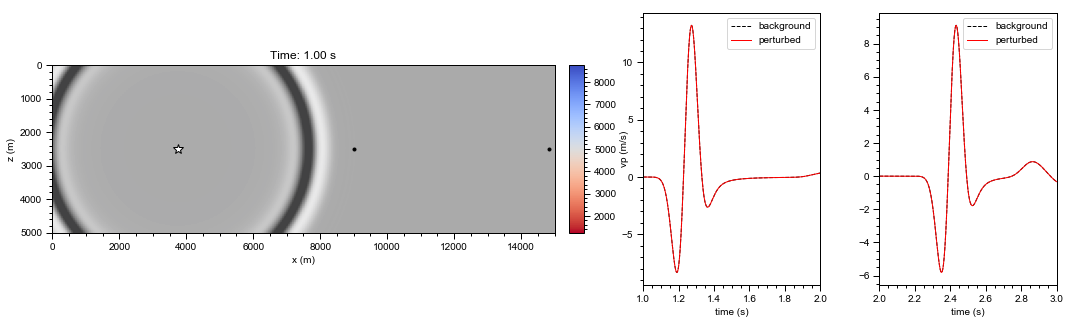

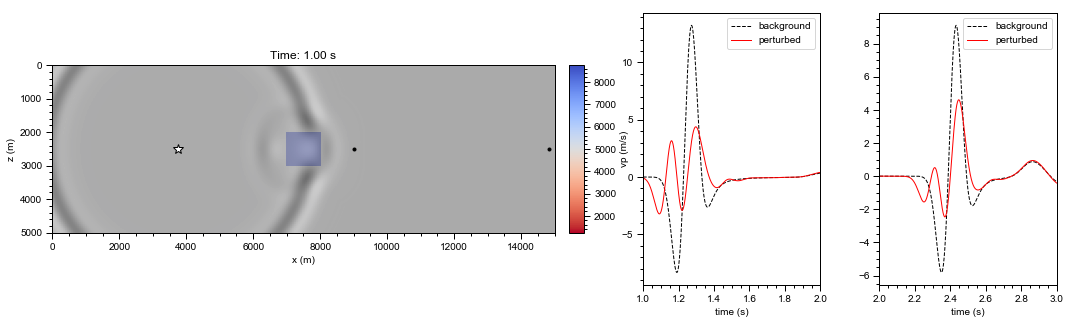

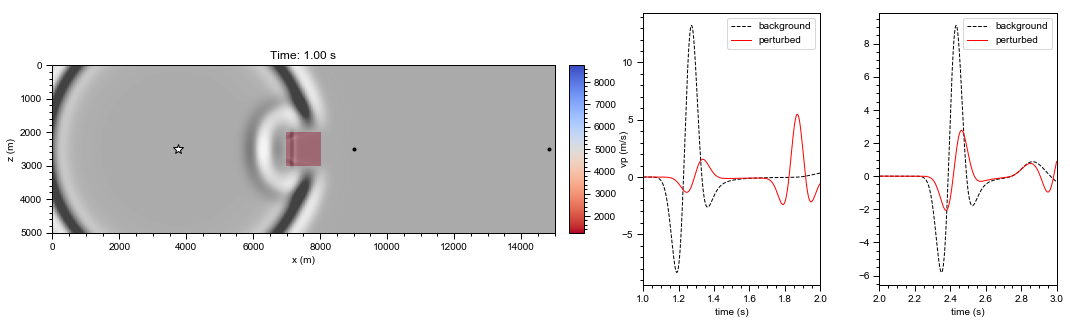

In [99]:
ts = 1000
kws = dict(trids=[-300,-10], tlim1=[1,2], tlim2=[2,3], figsize=(18,5), width_ratios=[3,1,1])
for sign in ['0', '+', '-']:
    plot(en, ts, sign=sign, **kws)

# v13: 

## Definitions

In [2]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=1000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:], 
                          extent=[self.b01.extent[0],self.b01.extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    s = [en.srcs['soux0'], en.srcs['souz']]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='vp (m/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [79]:
en = Ensemble('test', './', exe, anom_rad_per_wavelen=0.75, anom_amp=0.75)
en.init_pars(x2=1.5e4, ns=3000, babs=100, eabs=150)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [80]:
en.run()

rm: cannot remove './/test_75_75_minus//out/test_75_75_minus-Out0.log': No such file or directory
rm: cannot remove './/test_75_75_minus//out/test_75_75_minus-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 12 ms, total: 16 ms
Wall time: 16.6 s
rm: cannot remove './/test_75_75_null//out/test_75_75_null-Out0.log': No such file or directory
rm: cannot remove './/test_75_75_null//out/test_75_75_null-Err0.log': No such file or directory
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 16.6 s
rm: cannot remove './/test_75_75_plus//out/test_75_75_plus-Out0.log': No such file or directory
rm: cannot remove './/test_75_75_plus//out/test_75_75_plus-Err0.log': No such file or directory
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 17.1 s


In [81]:
en.prep_out()

## Output

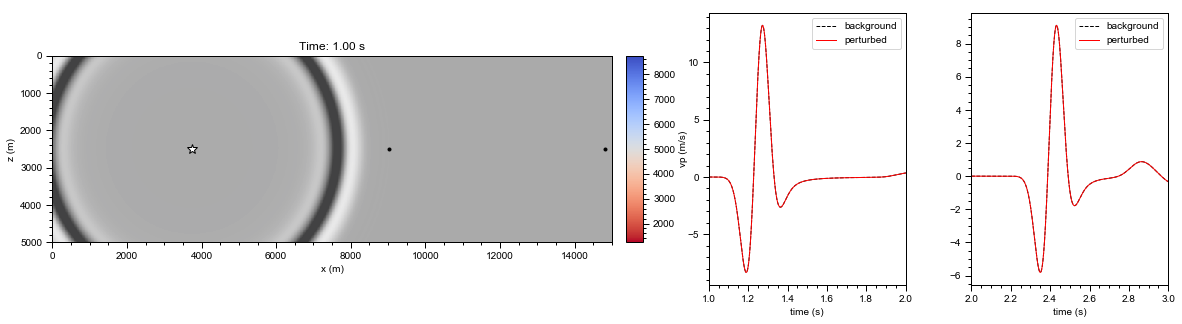

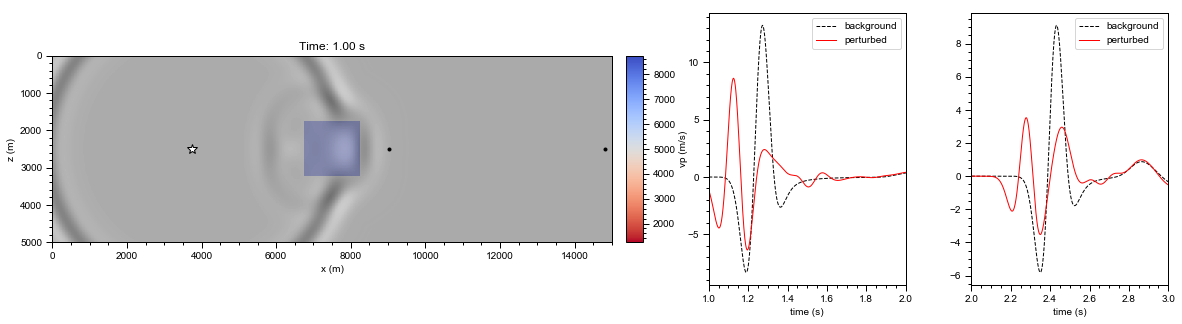

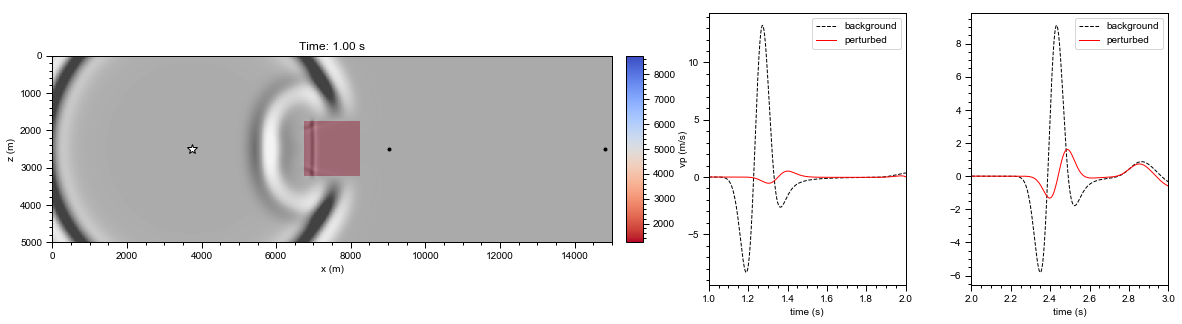

In [82]:
ts = 1000
kws = dict(trids=[-300,-10], tlim1=[1,2], tlim2=[2,3])
for sign in ['0', '+', '-']:
    plot(en, ts, sign=sign, **kws)

# v14: 

## Definitions

In [107]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=1000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        extent = np.array(extent) / 1000 # km
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            convert = 1000
            extent = np.array(self.b01.extent) / convert # km
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:]/convert, # convert to km/s
                          extent=[extent[0], extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp / 1000
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    convert = 1000
    s = [en.srcs['soux0']/convert, en.srcs['souz']/convert]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [30]:
en = Ensemble('test', './', exe, anom_rad_per_wavelen=0.5, anom_amp=0.75)
en.init_pars(x2=1.5e4, ns=3000, babs=100, eabs=150)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [8]:
en.run()

CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 17.7 s
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 16.5 s
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 16.5 s


In [31]:
en.prep_out()

## Output

CPU times: user 808 ms, sys: 304 ms, total: 1.11 s
Wall time: 416 ms


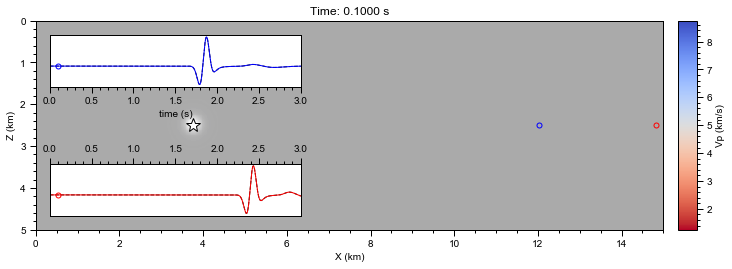

In [168]:
%%time 
for sign in ['0', '-', '+']:
    for ts in np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'b'
            rec2_c = 'r'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 1:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            #plt.close()
        break
    break

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 52.8 ms


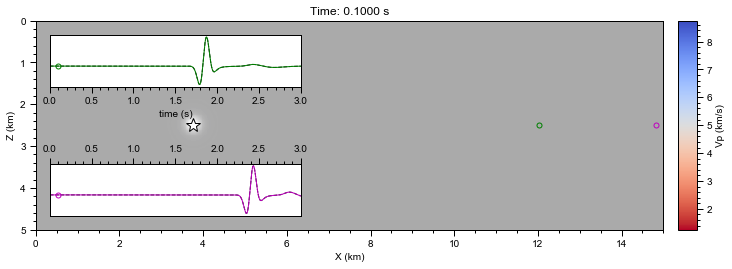

In [190]:
%%time 
for sign in ['0', '-', '+']:
    for ts in np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 0:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        #!cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif
        break
    break

# v15: finer sampling, extra nodes accordingly 

## Definitions

In [7]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=100000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        extent = np.array(extent) / 1000 # km
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            convert = 1000
            extent = np.array(self.b01.extent) / convert # km
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:]/convert, # convert to km/s
                          extent=[extent[0], extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp / 1000
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    convert = 1000
    s = [en.srcs['soux0']/convert, en.srcs['souz']/convert]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [208]:
en = Ensemble('finer', './', exe, anom_rad_per_wavelen=0.5, anom_amp=0.75)
en.init_pars(x2=1.5e4, dx=10, dt=0.0005, ns=6000, babs=200, eabs=250)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [209]:
en.run()

CPU times: user 4 ms, sys: 24 ms, total: 28 ms
Wall time: 1min 28s
CPU times: user 4 ms, sys: 20 ms, total: 24 ms
Wall time: 1min 26s
CPU times: user 4 ms, sys: 24 ms, total: 28 ms
Wall time: 1min 25s


In [210]:
en.prep_out()

## Output

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 53.5 ms


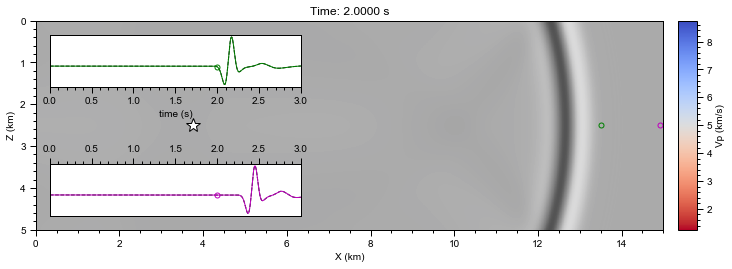

In [214]:
%%time 
for sign in ['0', '-', '+']:
    for ts in [4000]: #np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 0:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        #!cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif
        break
    break

In [215]:
%%time 
for sign in ['0', '-', '+']:
    for ts in np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 1:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        !cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif

CPU times: user 3min 12s, sys: 1min 41s, total: 4min 53s
Wall time: 12min 28s


# v16: finest (even finer), 50% again 

## Definitions

In [8]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=100000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        extent = np.array(extent) / 1000 # km
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            convert = 1000
            extent = np.array(self.b01.extent) / convert # km
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:]/convert, # convert to km/s
                          extent=[extent[0], extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp / 1000
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    convert = 1000
    s = [en.srcs['soux0']/convert, en.srcs['souz']/convert]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [216]:
en = Ensemble('finest', './', exe, anom_rad_per_wavelen=0.5, anom_amp=0.5)
en.init_pars(x2=1.5e4, dx=5, dt=0.00025, ns=12000, babs=200, eabs=250)
en.init_projs()
en.prep_inp()

Dominant wavelength in the background Vp: 1.0 km


## Run

In [217]:
en.run()

rm: cannot remove './/finest_50_50_plus//out/finest_50_50_plus-Out0.log': No such file or directory
rm: cannot remove './/finest_50_50_plus//out/finest_50_50_plus-Err0.log': No such file or directory
CPU times: user 12 ms, sys: 48 ms, total: 60 ms
Wall time: 8min 14s
rm: cannot remove './/finest_50_50_null//out/finest_50_50_null-Out0.log': No such file or directory
rm: cannot remove './/finest_50_50_null//out/finest_50_50_null-Err0.log': No such file or directory
CPU times: user 4 ms, sys: 56 ms, total: 60 ms
Wall time: 7min 57s
rm: cannot remove './/finest_50_50_minus//out/finest_50_50_minus-Out0.log': No such file or directory
rm: cannot remove './/finest_50_50_minus//out/finest_50_50_minus-Err0.log': No such file or directory
CPU times: user 8 ms, sys: 52 ms, total: 60 ms
Wall time: 7min 59s


In [218]:
en.prep_out()

## Output

CPU times: user 60 ms, sys: 32 ms, total: 92 ms
Wall time: 89.9 ms


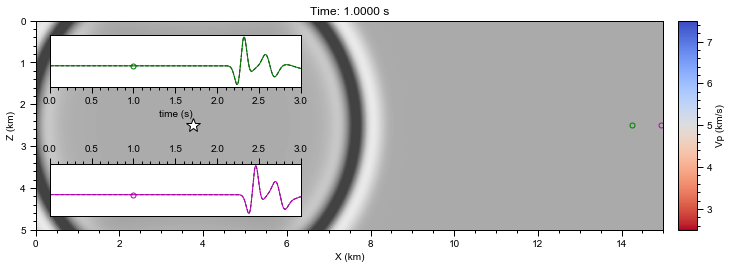

In [219]:
%%time 
for sign in ['0', '-', '+']:
    for ts in [4000]: #np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 0:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        #!cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif
        break
    break

In [ ]:
%%time 
for sign in ['0', '-', '+']:
    for ts in np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 1:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        !cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif

# v17: smaller, 75% again 

## Definitions

In [9]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=100000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        extent = np.array(extent) / 1000 # km
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            convert = 1000
            extent = np.array(self.b01.extent) / convert # km
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:]/convert, # convert to km/s
                          extent=[extent[0], extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp / 1000
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    convert = 1000
    s = [en.srcs['soux0']/convert, en.srcs['souz']/convert]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [ ]:
en = Ensemble('finest', './', exe, anom_rad_per_wavelen=0.25, anom_amp=0.75)
en.init_pars(x2=1.5e4, dx=5, dt=0.00025, ns=12000, babs=200, eabs=250)
en.init_projs()
en.prep_inp()

## Run

In [ ]:
en.run()

In [ ]:
en.prep_out()

## Output

In [ ]:
%%time 
for sign in ['0', '-', '+']:
    for ts in [4000]: #np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 0:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        #!cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif
        break
    break

In [ ]:
%%time 
for sign in ['0', '-', '+']:
    for ts in np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 1:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        !cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif

# v18: smaller, 50% again 

## Definitions

In [10]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=100000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        extent = np.array(extent) / 1000 # km
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            convert = 1000
            extent = np.array(self.b01.extent) / convert # km
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:]/convert, # convert to km/s
                          extent=[extent[0], extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp / 1000
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    convert = 1000
    s = [en.srcs['soux0']/convert, en.srcs['souz']/convert]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [ ]:
en = Ensemble('finest', './', exe, anom_rad_per_wavelen=0.25, anom_amp=0.50)
en.init_pars(x2=1.5e4, dx=5, dt=0.00025, ns=12000, babs=200, eabs=250)
en.init_projs()
en.prep_inp()

## Run

In [ ]:
en.run()

In [ ]:
en.prep_out()

## Output

In [ ]:
%%time 
for sign in ['0', '-', '+']:
    for ts in [4000]: #np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 0:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        #!cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif
        break
    break

In [ ]:
%%time 
for sign in ['0', '-', '+']:
    for ts in np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 1:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        !cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif

# v19: larger, 50% 

## Definitions

In [11]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=100000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        extent = np.array(extent) / 1000 # km
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            convert = 1000
            extent = np.array(self.b01.extent) / convert # km
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:]/convert, # convert to km/s
                          extent=[extent[0], extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp / 1000
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    convert = 1000
    s = [en.srcs['soux0']/convert, en.srcs['souz']/convert]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [ ]:
en = Ensemble('finest', './', exe, anom_rad_per_wavelen=0.75, anom_amp=0.50)
en.init_pars(x2=1.5e4, dx=5, dt=0.00025, ns=12000, babs=200, eabs=250)
en.init_projs()
en.prep_inp()

## Run

In [ ]:
en.run()

In [ ]:
en.prep_out()

## Output

In [ ]:
%%time 
for sign in ['0', '-', '+']:
    for ts in [4000]: #np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 0:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        #!cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif
        break
    break

In [ ]:
%%time 
for sign in ['0', '-', '+']:
    for ts in np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 1:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        !cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif

# v20: larger, weaker (25%) 

## Definitions

In [12]:
class Ensemble:
    def __init__(self, name, path, exe, anom_rad_per_wavelen, anom_amp):
        self.name = '%s_%0.f_%0.f' % (name, anom_rad_per_wavelen*100, anom_amp*100)  
        self.path = path
        self.exe = exe
        self.anom_rad_per_wavelen = anom_rad_per_wavelen
        self.anom_amp = anom_amp
    def init_pars(self, x1=0, x2=1e4, y1=0, y2=0, z1=0, z2=5e3, dx=20, ns=5000, dt=0.001,
             nth=100, soux0=None, vp=5000, fpeak=5, babs=50, eabs=100):
        self.nth = nth
        self.vp = vp
        self.fpeak = fpeak
        self.babs = babs
        self.eabs = eabs
        # Domain & its discretisation 
        b01 = Box(x1=x1, x2=x2, y1=y1, y2=y2, z1=z1, z2=z2)
        d01 = {'dt': dt, 'dx': dx, 'ns': ns}
        self.b01, self.d01 = b01, d01
        # Saving wavefield every nth time-step
        env = dict(SLAVES_WAVEFIELDSVTR=-nth)
        # Acquisition geometry
        z = (z2 - z1) / 2  # common depth of source, receivers and the centre of anomaly
        if soux0 is None:
            soux0 = (x2 - x1) / 4
        self.srcs = dict(souz=z, soux0=soux0, soudx=0, sounx=1) # single source
        self.recs = dict(recz=z, recx0=x1, recdx=dx, recnx=100000) # rec. at every node at z
        wavelen = vp / fpeak
        print('Dominant wavelength in the background Vp: %s km' % (wavelen / 1000))
        # Vp anomaly
        self.anom_pos = np.array([(x2 - x1) / 2, z]) // dx # centre of anomaly (nodes)
        self.anom_rad = wavelen * self.anom_rad_per_wavelen // dx # radius (nodes) 
        self.kws = dict(path=self.path, exe=self.exe, box=b01.box, **d01, env=env, cat=0)
    def init_projs(self):
        self.p = {}
        self.p['0'] = ProjSyn(self.name + '_null', **self.kws)
        self.p['-'] = ProjSyn(self.name + '_minus', **self.kws)
        self.p['+'] = ProjSyn(self.name + '_plus', **self.kws)    
    def prep_inp(self):
        for key, p in self.p.items():
            # Arrays
            bckg = np.full(p.dims, self.vp)
            anom = np.zeros(bckg.shape)
            [x, z], r = self.anom_pos.astype(int), int(self.anom_rad)
            sign = {'0': 0, '-': -1, '+': +1}
            anom[x-r:x+r+1, 0, z-r:z+r+1] = sign[key] * self.anom_amp    
            # Create input 
            p.i.rsg.create(wavelet='ricker', fpeak=self.fpeak)
            p.i.tvp.create(bckg + bckg * anom)
            # Preprocess 
            lll(40)
            p.i.sp.create(geometry='regular', geometry_in_nodes=False, ztype='d', 
                          **self.srcs, **self.recs)
            p.i.sp.run(cat=0)
            # Create runfile
            p.i.rnf.create(b_abs=self.babs, e_abs=self.eabs, btop=self.babs, etop=self.eabs)
    def run(self):
        for key, p in self.p.items():
            # Run locally 
            no = 0
            !rm {p.o.o.no[no].fname} {p.o.e.no[no].fname}
            p.i.bash.no[no].create(cat=1)
            %time p.i.bash.no[no].run()         
    def read_wavefields(self):
        from fullwavepy.seismic.wavefields import Wavefield
        from fullwavepy.utils import extent2absorb
        extent = extent2absorb(self.b01.extent, dx=self.d01['dx'], 
                               etop=self.eabs, e_abs=self.eabs)
        extent = np.array(extent) / 1000 # km
        for key, p in self.p.items():
            p.reinit('./')
            wfd = Wavefield()
            wfd.get_files(p.name, p.o.path)
            p.wf = {}
            sid = 1
            for ts, f in sorted(wfd.id[sid].items()):
                p.wf[ts] = Arr2d(f.read(overwrite=0)[:,0,:], 
                                 extent=[extent[0],extent[-1]])          
    def read_gathers(self):
        for key, p in self.p.items():
            p.reinit('./')
            p.dat = Arr2d(p.o.syn.read()[:,0,:])
    def read_models(self):
        for key, p in self.p.items():
            p.reinit('./')
            convert = 1000
            extent = np.array(self.b01.extent) / convert # km
            p.tvp = Arr2d(p.i.tvp.read(overwrite_mmp=1)[:,0,:]/convert, # convert to km/s
                          extent=[extent[0], extent[-1]])    
    def prep_out(self):
        self.read_models()
        self.read_gathers()
        self.read_wavefields()
def vmin_vmax(en):
    vp = en.vp / 1000
    anom_amp = en.anom_amp
    vmin = vp + vp*anom_amp
    vmax = vp - vp*anom_amp
    if anom_amp > 0:
        vmin, vmax = vmax, vmin    
    elif anom_amp == 0:
        vmin, vmax = None, None
    return vmin, vmax
def plot_src(en, size=10):
    convert = 1000
    s = [en.srcs['soux0']/convert, en.srcs['souz']/convert]
    plt.plot(*s, marker='*', markeredgecolor='k', markerfacecolor='w', markersize=size)
def plot(en, ts, sign='-', trids=[-150,-10], ref='0', clip=500, alpha=.7, 
         tlim1=[.8,2.2], tlim2=[.8,2.2]):
    # Prerequisites
    x1, x2, y1, y2, z1, z2 = en.b01.box
    dx = en.d01['dx']
    dt = en.d01['dt']
    recx = np.arange(x1, x2+dx, dx)
    z = (z2 - z1) / 2
    # Figure
    fig = plt.figure(figsize=(20,5))
    gs = GridSpec(1, 3, width_ratios=[3,1,1])
    p = en.p[sign]
    p_ref = en.p[ref]
    fig.add_subplot(gs[0,0])
    vmin, vmax = vmin_vmax(en)
    p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
    p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
    plt.xlabel('x (km)')
    plt.ylabel('z (km)')
    plt.xlim(p.tvp.axes[0].extent)
    plt.ylim(p.tvp.axes[1].extent)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal') 
    plt.title('Time: %1.2f s' % (ts * dt))

    plot_src(en)
    plt.plot(recx[trids[0]], z, '.', c='k')
    plt.plot(recx[trids[1]], z, '.', c='k')
    for i in range(2):
        fig.add_subplot(gs[0, 1+i])
        trid = trids[i]
        time = np.arange(en.d01['ns']) * dt
        plt.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
        plt.plot(time, p.dat.arr[trid,:], 'r-', label='perturbed')
        if i == 0:
            plt.xlim(tlim1)
        else:
            plt.xlim(tlim2)
        plt.xlabel('time (s)')
        plt.legend()        

## Input

In [ ]:
en = Ensemble('finest', './', exe, anom_rad_per_wavelen=0.75, anom_amp=0.25)
en.init_pars(x2=1.5e4, dx=5, dt=0.00025, ns=12000, babs=200, eabs=250)
en.init_projs()
en.prep_inp()

## Run

In [ ]:
en.run()

In [ ]:
en.prep_out()

## Output

In [ ]:
%%time 
for sign in ['0', '-', '+']:
    for ts in [4000]: #np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 0:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        #!cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif
        break
    break

In [ ]:
%%time 
for sign in ['0', '-', '+']:
    for ts in np.arange(en.nth, en.d01['ns']+1, en.nth):
        if 1:
            ref = '0'
            rec1_c = 'g'
            rec2_c = 'm'
            clip=500
            alpha=.7 
            trids=[-150,-10]
            tmax = en.d01['ns']*en.d01['dt']
            tlims = [[0, tmax], [0, tmax]] #[[1,2],[2,3]]
        if 1:
            # Prerequisites
            x1, x2, y1, y2, z1, z2 = en.b01.box
            dx = en.d01['dx']
            dt = en.d01['dt']
            recx = np.arange(x1, x2+dx, dx)
            z = (z2 - z1) / 2
            vmin, vmax = vmin_vmax(en)
            p = en.p[sign]
            p_ref = en.p[ref]
        if 1:
            fig = figure(10,5)
            fig.set_tight_layout(dict(pad=.1))
            gs = GridSpec(1,1)
            ax = fig.add_subplot(gs[0])
            p.tvp.plot(vmin=vmin, vmax=vmax, cmap='coolwarm_r', label='Vp (km/s)')
            p.wf[ts].plot(cmap='Greys', vmin=-clip, vmax=clip, alpha=alpha, cbar=0)
            plot_src(en, size=15)
            convert = 1000
            recx = np.arange(x1, x2+dx, dx) / convert
            z = (z2 - z1) / 2 / convert
            kw_rec = dict(marker='.', markerfacecolor='None', markersize=10)
            plt.plot(recx[trids[0]], z, markeredgecolor=rec1_c, **kw_rec)
            plt.plot(recx[trids[1]], z, markeredgecolor=rec2_c, **kw_rec)    
            ax.set_xlabel('X (km)')
            ax.set_ylabel('Z (km)')
            ax.set_xlim(p.tvp.axes[0].extent)
            ax.set_ylim(p.tvp.axes[1].extent)
            ax.invert_yaxis()
            ax.set_aspect('equal') 
            ax.set_title('Time: %1.4f s' % (ts * dt))    
        if 1:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
            time = np.arange(en.d01['ns']) * dt
            for i in range(2):
                trid = trids[i]
                if i == 0:
                    rec_c = rec1_c
                    loc  = 'upper left' 
                    tick_pars = dict(which='both', bottom=1, top=0, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=1, labeltop=0, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel='time (s)', xlim=tlims[i], yticks=[], ylabel='')
                else:
                    rec_c = rec2_c
                    loc = 'lower left'
                    tick_pars = dict(which='both', bottom=0, top=1, left=0, right=0,)
                    tick_lab_pars = dict(labelbottom=0, labeltop=1, labelleft=0, labelright=0)
                    ax_pars = dict(xlabel=None, xlim=tlims[i], yticks=[], ylabel='')
                axins = inset_axes(ax, loc=loc, width='40%', height='25%', borderpad=1.4,
                                     )
                axins.plot(time, p_ref.dat.arr[trid,:], 'k--', label='background')
                axins.plot(time, p.dat.arr[trid,:], '-', c=rec_c, label='perturbed')
                axins.plot(ts * en.d01['dt'], p_ref.dat.arr[trid,ts-1], 
                           marker='o', markersize=5, markeredgecolor=rec_c, markerfacecolor='None')
                axins.set(**ax_pars)
                axins.tick_params(**tick_pars)
                axins.tick_params(**tick_lab_pars)
        if 1:
            fname = 'figures/%s_%s' % (p.name, str(ts).rjust(6, '0')) 
            plt.savefig(fname)
            plt.close()
        
        !cd figures; convert -delay 20 -loop 0 {p.name}_*.png {p.name}.gif

# Sandbox

## transparency

In [182]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, *, data=None, **kwargs)
    Display an image, i.e. data on a 2D regular raster.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The data is visualized
          using a colormap.
        - (M, N, 3): an image with RGB values (float or uint8).
        - (M, N, 4): an image with RGBA values (float or uint8), i.e.
          including transparency.
    
        The first two dimensions (M, N) define the rows and columns of
        the image.
    
        The RGB(A) values should be in the range [0 .. 1] for floats or
        [0 .. 255] for integers.  Out-of-range values will be clipped to
        these bounds.
    
   

In [181]:
from matplotlib.colors import Normalize

a = np.zeros((3,3))
a[1,1] = 1
alphas = np.ones(a.shape)
# Create an alpha channel based on weight values
# Any value whose absolute value is > .0001 will have zero transparency
alphas = Normalize(0, .3, clip=True)(np.abs(a))
# alphas = np.clip(alphas, .4, 1)  # alpha value clipped at the bottom at .4
# plt.imshow(alphas)
plt.imshow(a, alpha=alphas)
# plt.colorbar()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f50c314bea0> (for post_execute):


ValueError: operands could not be broadcast together with shapes (218,218) (3,3) 

ValueError: operands could not be broadcast together with shapes (218,218) (3,3) 

<Figure size 432x288 with 1 Axes>

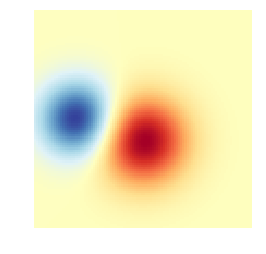

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


def normal_pdf(x, mean, var):
    return np.exp(-(x - mean)**2 / (2*var))


# Generate the space in which the blobs will live
xmin, xmax, ymin, ymax = (0, 100, 0, 100)
n_bins = 100
xx = np.linspace(xmin, xmax, n_bins)
yy = np.linspace(ymin, ymax, n_bins)

# Generate the blobs. The range of the values is roughly -.0002 to .0002
means_high = [20, 50]
means_low = [50, 60]
var = [150, 200]

gauss_x_high = normal_pdf(xx, means_high[0], var[0])
gauss_y_high = normal_pdf(yy, means_high[1], var[0])

gauss_x_low = normal_pdf(xx, means_low[0], var[1])
gauss_y_low = normal_pdf(yy, means_low[1], var[1])

weights = (np.outer(gauss_y_high, gauss_x_high)
           - np.outer(gauss_y_low, gauss_x_low))

# We'll also create a grey background into which the pixels will fade
greys = np.full((*weights.shape, 3), 70, dtype=np.uint8)

# First we'll plot these blobs using ``imshow`` without transparency.
vmax = np.abs(weights).max()
imshow_kwargs = {
    'vmax': vmax,
    'vmin': -vmax,
    'cmap': 'RdYlBu',
    'extent': (xmin, xmax, ymin, ymax),
}

fig, ax = plt.subplots()
ax.imshow(greys)
ax.imshow(weights, **imshow_kwargs)
ax.set_axis_off()

In [180]:
# Create an alpha channel based on weight values
# Any value whose absolute value is > .0001 will have zero transparency
alphas = Normalize(0, .3, clip=True)(np.abs(weights))
alphas = np.clip(alphas, .4, 1)  # alpha value clipped at the bottom at .4

# Create the figure and image
# Note that the absolute values may be slightly different
fig, ax = plt.subplots()
ax.imshow(greys)
ax.imshow(weights, alpha=alphas, **imshow_kwargs)

# Add contour lines to further highlight different levels.
ax.contour(weights[::-1], levels=[-.1, .1], colors='k', linestyles='-')
ax.set_axis_off()
plt.show()

ax.contour(weights[::-1], levels=[-.0001, .0001], colors='k', linestyles='-')
ax.set_axis_off()
plt.show()

ValueError: operands could not be broadcast together with shapes (217,217) (100,100) 

<Figure size 432x288 with 1 Axes>

## mark_inset

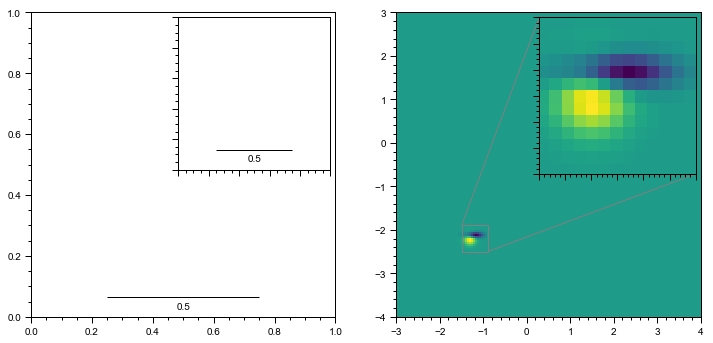

In [13]:
# code 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
def get_demo_image():
    from matplotlib.cbook import get_sample_data
    import numpy as np
    f = get_sample_data("axes_grid/bivariate_normal.npy", asfileobj=False)
    z = np.load(f)
    # z is a numpy array of 15x15
    return z, (-3, 4, -4, 3)
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=[12, 6])

# First subplot, showing an inset with a size bar.
if 1:
    ax.set_aspect(1)

    axins = zoomed_inset_axes(ax, zoom=0.5, loc='upper right')
    # fix the number of ticks on the inset axes
    axins.yaxis.get_major_locator().set_params(nbins=7)
    axins.xaxis.get_major_locator().set_params(nbins=7)

    plt.setp(axins.get_xticklabels(), visible=False)
    plt.setp(axins.get_yticklabels(), visible=False)


    def add_sizebar(ax, size):
        asb = AnchoredSizeBar(ax.transData,
                              size,
                              str(size),
                              loc=8,
                              pad=0.1, borderpad=0.5, sep=5,
                              frameon=False)
        ax.add_artist(asb)

    add_sizebar(ax, 0.5)
    add_sizebar(axins, 0.5)


# Second subplot, showing an image with an inset zoom and a marked inset
if 1:
    Z, extent = get_demo_image()
    Z2 = np.zeros([150, 150], dtype="d")
    ny, nx = Z.shape
    Z2[30:30 + ny, 30:30 + nx] = Z

    # extent = [-3, 4, -4, 3]
    ax2.imshow(Z2, extent=extent, interpolation="nearest",
              origin="lower")


    axins2 = zoomed_inset_axes(ax2, 6, loc=1)  # zoom = 6
    axins2.imshow(Z2, extent=extent, interpolation="nearest",
                  origin="lower")
    # sub region of the original image
    x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
    axins2.set_xlim(x1, x2)
    axins2.set_ylim(y1, y2)
    # fix the number of ticks on the inset axes
    axins2.yaxis.get_major_locator().set_params(nbins=7)
    axins2.xaxis.get_major_locator().set_params(nbins=7)

    plt.setp(axins2.get_xticklabels(), visible=False)
    plt.setp(axins2.get_yticklabels(), visible=False)

    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.show()


# ...